# API

In [2]:
# %%writefile GMM.py
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from sklearn.pipeline import Pipeline
import pickle
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from matplotlib.animation import FuncAnimation
class GMM_model:
    def __init__(self,filename,mask=None):
        '''
        rs: (T_idx,x_idx,y_idx)
        mask: ((x_min,x_max),(y_min,y_max))
        '''
        self.filename=filename
        self.mask=mask
        self.rs=self.load()
        self.labels_={}
        self.X_orig={}
        self.X={}
        self.bic={}
        self.silhouette={}
        self.search={}
        self.labels_grid={}

    def load(self):
        with open(self.filename,'rb') as f:
            rs=pickle.load(f)
        # if self.mask is not None:
        #     for key in ['mean','std','length']:
        #         rs[key]=rs[key][:,self.mask[0][0]:self.mask[0][1],self.mask[1][0]:self.mask[1][1]]
        #     rs['x']=np.arange(self.mask[0][0],self.mask[0][1])
        #     rs['y']=np.arange(self.mask[1][0],self.mask[1][1])
        if self.mask is None:
            self.mask=(np.ones(rs['mean'].shape[1:])==1)
        rs['T']=rs['T']+273
        return rs

    def preprocessing(self,kind):
        self.X_orig[kind]=self.rs[kind][:,self.mask].T
        # self.X_orig[kind]=self.rs[kind].reshape((self.rs[kind].shape[0],-1)).T

        # estimators=[('standardize',StandardScaler()),]
        estimators=[('T',FunctionTransformer(lambda x:x.T)),('standardize',StandardScaler()),('T2',FunctionTransformer(lambda x:x.T)),]

        pipeline=Pipeline(estimators)
        self.X[kind]=pipeline.fit_transform(self.X_orig[kind])
        
    def GMM_fit(self,kind,k=3):
        self.preprocessing(kind)
        self.k=k
        self.gm=GaussianMixture(n_components=self.k)
        self.labels_[kind]=self.gm.fit_predict(self.X[kind])
        
    
    def GMM_hypertuning(self,kind,k_range=np.arange(2,7),trial=10):
        self.bic[kind]=pd.DataFrame()
        self.silhouette[kind]=pd.DataFrame()
        if not kind in self.X:
            self.preprocessing(kind)
        for k in k_range:
            bic_k=[]
            silhouette_k=[]
            for i in range(trial):
                print('\r k={} i={}'.format(k,i),end='',flush=True)
                self.GMM_fit(kind,k)
                self.gm.fit(self.X[kind])    
                bic_k.append(self.gm.bic(self.X[kind]))
                silhouette_k.append(silhouette_score(self.X[kind],self.gm.fit_predict(self.X[kind])))
            self.bic[kind][k]=bic_k
            self.silhouette[kind][k]=silhouette_k
    
    def GMM_hypertuning_GridSearchCV(self,kind,k_range=np.arange(2,7),trial=10):
        if not kind in self.search:
            if not kind in self.X:
                self.preprocessing(kind)
            def scoring(clf,X):
                labels_=clf.fit_predict(self.X[kind])
                return {'bic':clf.bic(self.X[kind]),'silhouette':silhouette_score(self.X[kind], labels_)}
            self.k_range=k_range
            self.search[kind]=GridSearchCV(GaussianMixture(n_init=trial), param_grid={"n_components":k_range},n_jobs=-1,return_train_score=True,scoring=scoring,verbose=4,cv=[(slice(None), slice(None))],refit=False)
            self.search[kind].fit(self.X[kind])


    def GMM_plot(self,kind,permutation=None,ax=None):
        if permutation is None:
            permutation=np.arange(self.k)
        offset=permutation-np.arange(self.k)
        if ax is None:
            fig, ax= plt.subplots(1,3,figsize=(13,4),tight_layout=True)
        cmap = plt.get_cmap('plasma', self.k)
        bounds = np.arange(self.k+1)-0.5
        norm = colors.BoundaryNorm(bounds, cmap.N)
        labels_=self.labels_[kind]
        labels_offset=np.array([offset[labels_[idx]] for idx in range(labels_.shape[0])])
        labels_=labels_+labels_offset
        cnt=0
        self.labels_grid[kind]=np.zeros(self.rs['mean'].shape[1:],)
        for i in self.rs['x']:
            for j in self.rs['y']:
                if self.mask[i,j]:
                    self.labels_grid[kind][i,j]=labels_[cnt]
                    cnt+=1
                else:
                    self.labels_grid[kind][i,j]=np.nan

        
        im=ax[0].imshow(self.labels_grid[kind],cmap=cmap,norm=norm,extent=(self.rs['y'][0],self.rs['y'][-1],self.rs['x'][-1],self.rs['x'][0]))
        cb=plt.colorbar(im,ax=ax[0],ticks=np.arange(self.k),boundaries=bounds)
        cb.ax.set_yticklabels([f'{i}' for i in range(self.k)])
        bic_text='BIC={:.0f}, Silhouette={:.2f}'.format(self.gm.bic(self.X[kind]),silhouette_score(self.X[kind],labels_))
        for idx in range(self.k):
            bic_text=bic_text+'\n{}:{}'.format(idx,np.sum(labels_==idx))
        ax[0].set_title(bic_text)
        ax[0].set_xlabel('y')
        ax[0].set_ylabel('x')

        color_list=[cmap(idx) for idx in range(self.k)]
        for n,color in zip(range(self.k),color_list):
            mean=self.X[kind][labels_==n].T.mean(axis=-1)
            ax[1].plot(self.rs['T'],mean,color=color,label=str(n))
            error=self.X[kind][labels_==n].T.std(axis=-1)
            ax[1].fill_between(self.rs['T'],mean-error,mean+error,color=color,alpha=0.5)
        ax[1].set_xlabel('T (K)')
        ax[1].set_ylabel('z-score of {}'.format(kind))
        ax[1].legend()

        for n,color in zip(range(self.k),color_list):
            mean=self.X_orig[kind][labels_==n].T.mean(axis=-1)
            ax[2].plot(self.rs['T'],mean,color=color,label=str(n))
            error=self.X_orig[kind][labels_==n].T.std(axis=-1)
            ax[2].fill_between(self.rs['T'],mean-error,mean+error,color=color,alpha=0.5)
        ax[2].set_xlabel('T (K)')
        ax[2].set_ylabel(kind)
        ax[2].legend()

    def GMM_plot_single(self,kind,cluster_list,cond=None,errorbar=True,ax=None,ylim=None):
        if ax is None:
            fig,ax=plt.subplots()
        labels_=self.labels_[kind]

        cmap = plt.get_cmap('plasma', self.k)
        color_list=[cmap(idx) for idx in range(self.k)]
        for n in cluster_list:
            mean=self.X_orig[kind][labels_==n].T.mean(axis=-1)
            ax.plot(self.rs['T'],mean,color=color_list[n],label=str(n))
            if errorbar:
                error=self.X_orig[kind][labels_==n].T.std(axis=-1)
                ax.fill_between(self.rs['T'],mean-error,mean+error,color=color_list[n],alpha=0.5)
        ax.set_xlabel('T (K)')
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.set_ylabel(kind)
        ax.legend()
        if cond is not None:
            ax2=ax.twinx()
            ax2.plot(cond[:,0],cond[:,1],color='k',ls='dashed')
            ax2.set_xlim(self.rs['T'][0],self.rs['T'][-1])
            ax2.set_ylabel('R ($\Omega$)')
            ax2.tick_params(axis='y', labelcolor='k')

    def convert_real_space(self,kind):
        labels_grid=self.labels_grid[kind]
        self.ij={}
        for i in (self.rs['x']):
            for j in (self.rs['y']):
                label=-1 if np.isnan(labels_grid[i,j]) else labels_grid[i,j]
                if label in self.ij:
                    self.ij[label].append((i,j))
                else:
                    self.ij[label]=[]
        
        # for cluster in range(self.k):
        #     idx,=np.where(labels_==cluster)
        #     self.ij[cluster]=np.unravel_index(idx, self.rs[kind].shape[1:])
        return self.ij



# Dataset 1

## Transport

In [2]:
T = np.array([-156, -110, -105, -100, -95, -90, -85, -80, -77, -74, -71, -68, -65, -62, -59, -56, -53, -48, 25, 127])+273
R = np.array([1031.4, 1046.9, 1043.7, 1030.05, 1002.8, 979.8, 949.9, 909.6, 879.3, 832.2, 713.6, 416.1, 307.7, 285.7, 282.1, 281.7, 281.7, 279.5, 265.2, 266.7])


## all_peaks_1

In [3]:
all_peaks=GMM_model('q_Txy_all_peaks_1.pickle')

In [4]:
all_peaks.GMM_hypertuning_GridSearchCV('mean',trial=10)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=319428.183, test=319428.187) silhouette: (train=0.307, test=0.307) total time=  19.6s
[CV 1/1] END n_components=3; bic: (train=301263.166, test=301261.773) silhouette: (train=0.108, test=0.108) total time=  21.8s
[CV 1/1] END n_components=4; bic: (train=260707.590, test=260707.579) silhouette: (train=0.073, test=0.073) total time=  26.7s
[CV 1/1] END n_components=5; bic: (train=251825.062, test=251893.315) silhouette: (train=0.003, test=-0.003) total time=  49.4s
[CV 1/1] END n_components=6; bic: (train=247565.099, test=247552.680) silhouette: (train=-0.007, test=-0.007) total time= 1.0min


Text(0, 0.5, 'Silhouette Score')

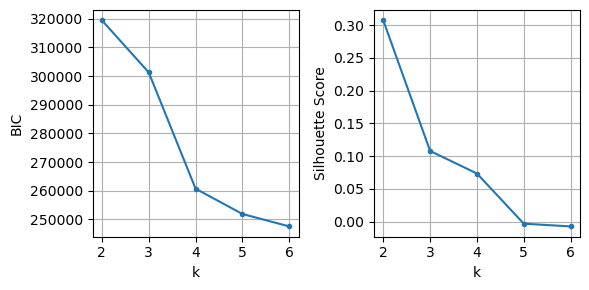

In [5]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(all_peaks.k_range,all_peaks.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(all_peaks.k_range,all_peaks.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(all_peaks.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

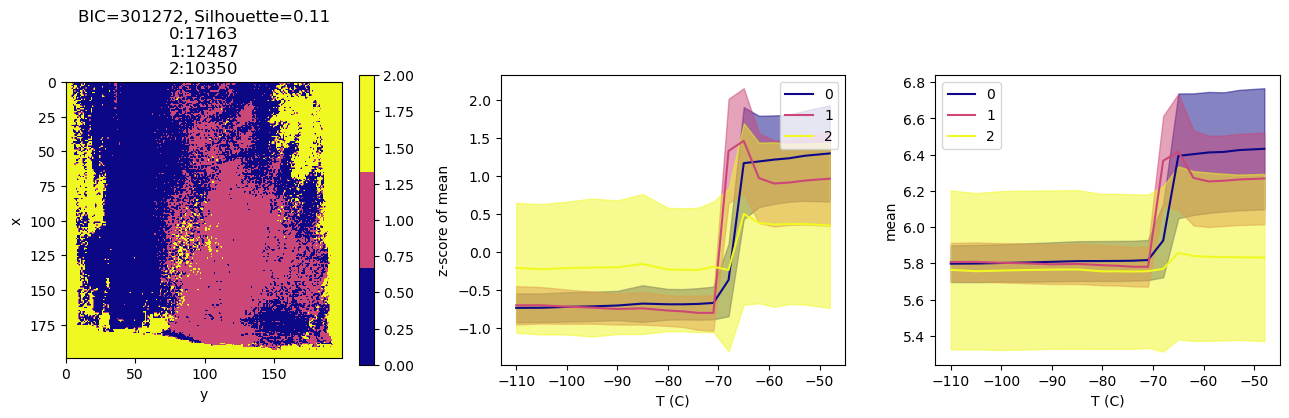

In [6]:
all_peaks.GMM_fit('mean',k=3)
all_peaks.GMM_plot('mean',[1,0,2])

In [22]:
all_peaks.GMM_hypertuning_GridSearchCV('std',trial=10)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=69367.790, test=69367.790) silhouette: (train=0.476, test=0.476) total time=  19.3s
[CV 1/1] END n_components=3; bic: (train=41435.753, test=41435.539) silhouette: (train=0.181, test=0.181) total time=  23.1s
[CV 1/1] END n_components=4; bic: (train=-1975.853, test=-1975.211) silhouette: (train=0.070, test=0.070) total time=  37.1s
[CV 1/1] END n_components=5; bic: (train=-11843.369, test=-11878.616) silhouette: (train=0.046, test=0.045) total time=  47.6s
[CV 1/1] END n_components=6; bic: (train=-23847.378, test=-23876.764) silhouette: (train=0.020, test=0.020) total time=  49.1s


Text(0, 0.5, 'Silhouette Score')

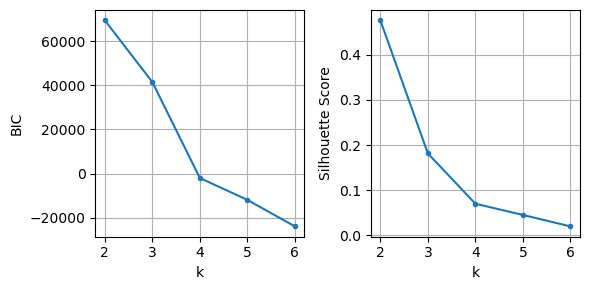

In [27]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(all_peaks.k_range,all_peaks.search['std'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(all_peaks.k_range,all_peaks.search['std'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(all_peaks.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

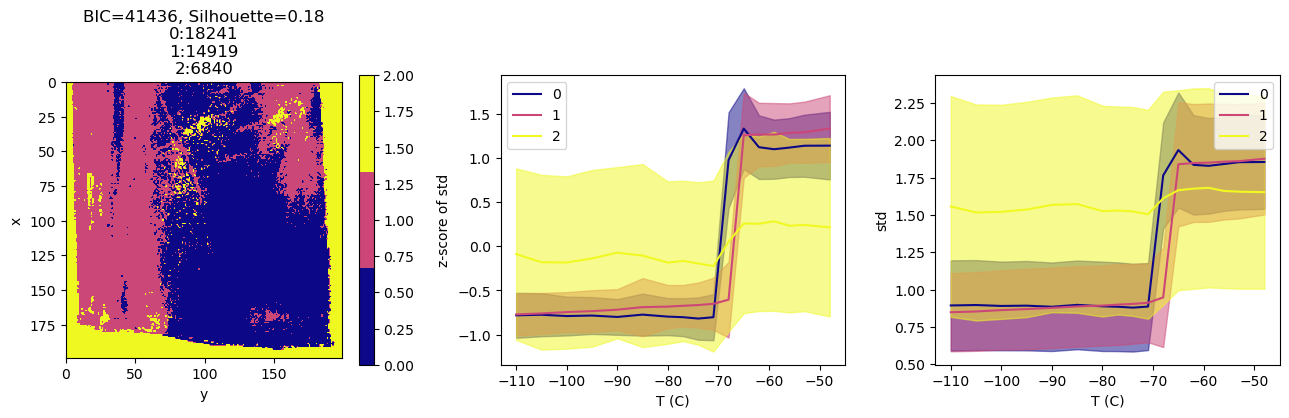

In [10]:
# all_peaks.GMM_fit('std',k=3)
all_peaks.GMM_plot('std',)

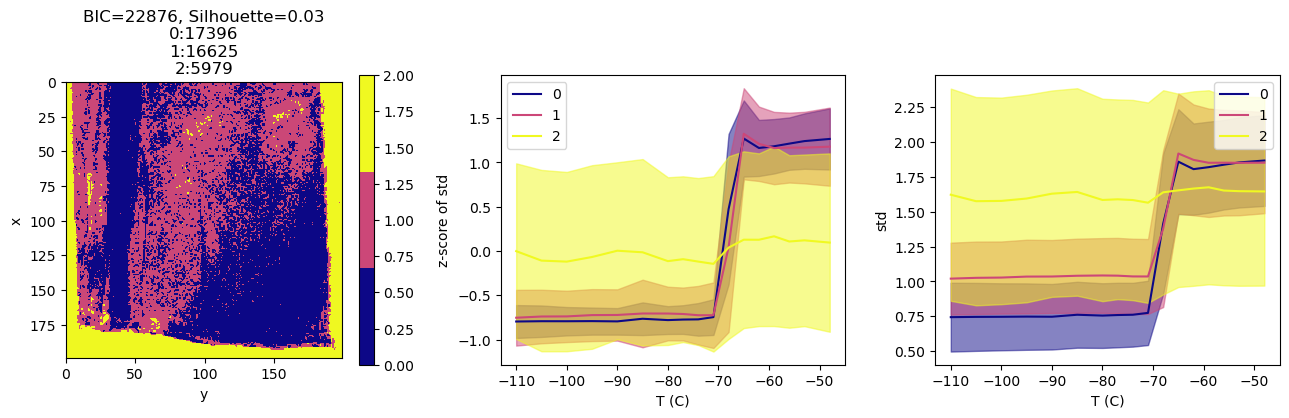

In [ ]:
all_peaks.GMM_fit('std',k=3)
all_peaks.GMM_plot('std',[1,0,2])

In [23]:
all_peaks.GMM_hypertuning_GridSearchCV('length',trial=10)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=-321982.761, test=-321982.761) silhouette: (train=0.554, test=0.554) total time=  20.2s
[CV 1/1] END n_components=3; bic: (train=-380575.773, test=-380249.061) silhouette: (train=0.123, test=0.286) total time=  22.5s
[CV 1/1] END n_components=4; bic: (train=-422033.714, test=-422068.740) silhouette: (train=0.195, test=0.189) total time=  43.2s
[CV 1/1] END n_components=5; bic: (train=-445574.344, test=-445605.961) silhouette: (train=0.099, test=0.099) total time=  51.6s
[CV 1/1] END n_components=6; bic: (train=-454576.967, test=-452520.846) silhouette: (train=0.075, test=0.093) total time= 1.2min


Text(0, 0.5, 'Silhouette Score')

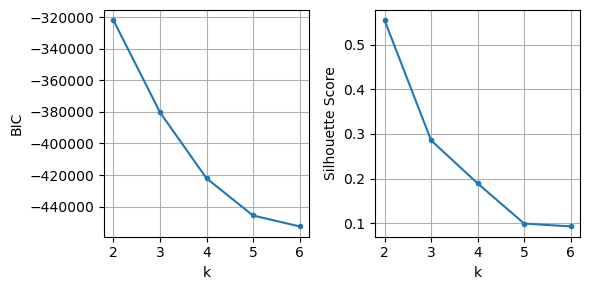

In [28]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(all_peaks.k_range,all_peaks.search['length'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(all_peaks.k_range,all_peaks.search['length'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(all_peaks.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

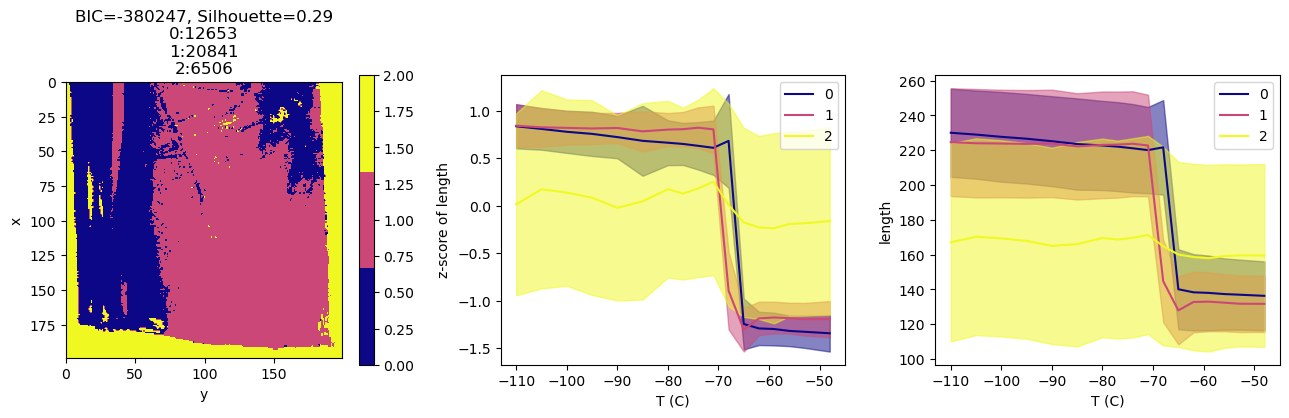

In [30]:
all_peaks.GMM_fit('length',k=3)
all_peaks.GMM_plot('length',[1,0,2])

## all_peaks_1_outlier

In [20]:
all_peaks_outlier=GMM_model('q_Txy_all_peaks_outlier_1.pickle')

In [12]:
all_peaks_outlier.GMM_hypertuning_GridSearchCV('mean',trial=10)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=806783.112, test=806783.067) silhouette: (train=0.142, test=0.142) total time=  18.7s
[CV 1/1] END n_components=3; bic: (train=781401.688, test=781404.216) silhouette: (train=0.023, test=0.023) total time=  27.5s
[CV 1/1] END n_components=4; bic: (train=769515.014, test=769540.423) silhouette: (train=-0.018, test=-0.017) total time=  53.2s
[CV 1/1] END n_components=5; bic: (train=764277.517, test=763860.691) silhouette: (train=-0.035, test=-0.019) total time=  57.9s
[CV 1/1] END n_components=6; bic: (train=760590.738, test=760463.811) silhouette: (train=-0.033, test=-0.048) total time= 1.1min


Text(0, 0.5, 'Silhouette Score')

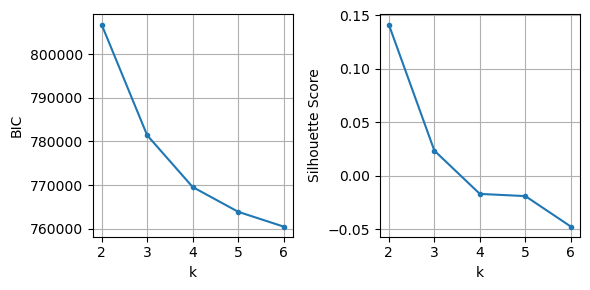

In [13]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(all_peaks_outlier.k_range,all_peaks_outlier.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(all_peaks_outlier.k_range,all_peaks_outlier.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(all_peaks_outlier.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

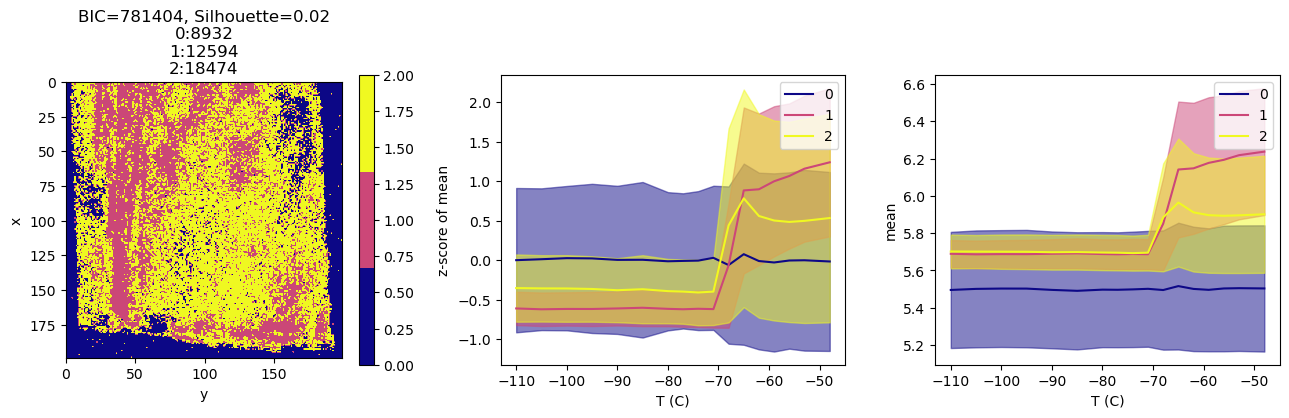

In [12]:
# all_peaks_outlier.GMM_fit('mean',k=3)
all_peaks_outlier.GMM_plot('mean',)

In [ ]:
all_peaks_outlier.GMM_hypertuning_GridSearchCV('std',trial=10)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=617416.270, test=617416.270) silhouette: (train=0.213, test=0.213) total time=  20.9s
[CV 1/1] END n_components=3; bic: (train=516217.550, test=516217.616) silhouette: (train=-0.030, test=-0.030) total time=  29.4s
[CV 1/1] END n_components=4; bic: (train=499896.696, test=499895.683) silhouette: (train=-0.050, test=-0.050) total time=  36.3s
[CV 1/1] END n_components=5; bic: (train=483689.747, test=483575.230) silhouette: (train=-0.037, test=-0.038) total time= 1.0min
[CV 1/1] END n_components=6; bic: (train=467690.397, test=471543.558) silhouette: (train=-0.075, test=-0.065) total time= 1.2min


Text(0, 0.5, 'Silhouette Score')

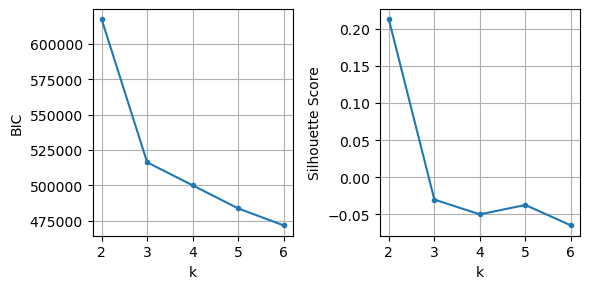

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(all_peaks_outlier.k_range,all_peaks_outlier.search['std'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(all_peaks_outlier.k_range,all_peaks_outlier.search['std'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(all_peaks_outlier.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

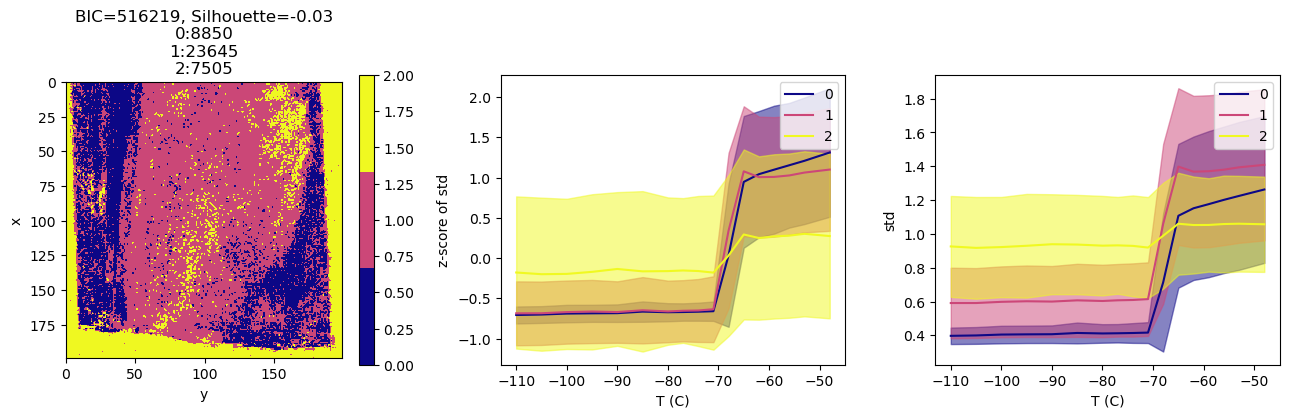

In [21]:
all_peaks_outlier.GMM_fit('std',k=3)
all_peaks_outlier.GMM_plot('std',)

In [22]:
all_peaks_outlier.GMM_hypertuning_GridSearchCV('length',trial=10)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=-196256.842, test=-196256.843) silhouette: (train=0.539, test=0.539) total time=  20.4s
[CV 1/1] END n_components=3; bic: (train=-255305.913, test=-255306.340) silhouette: (train=0.059, test=0.059) total time=  24.4s
[CV 1/1] END n_components=4; bic: (train=-290753.825, test=-290753.549) silhouette: (train=0.126, test=0.126) total time=  44.1s
[CV 1/1] END n_components=5; bic: (train=-317153.803, test=-318353.775) silhouette: (train=0.077, test=0.063) total time=  58.6s
[CV 1/1] END n_components=6; bic: (train=-326268.358, test=-332481.232) silhouette: (train=0.048, test=0.012) total time= 1.3min


Text(0, 0.5, 'Silhouette Score')

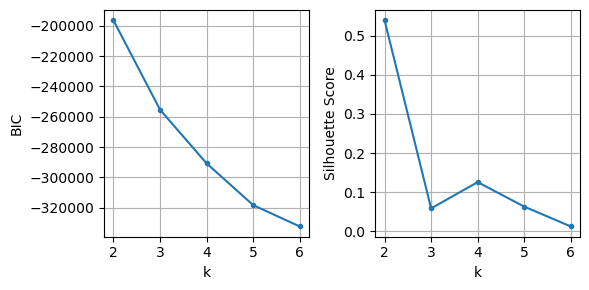

In [23]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(all_peaks_outlier.k_range,all_peaks_outlier.search['length'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(all_peaks_outlier.k_range,all_peaks_outlier.search['length'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(all_peaks_outlier.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

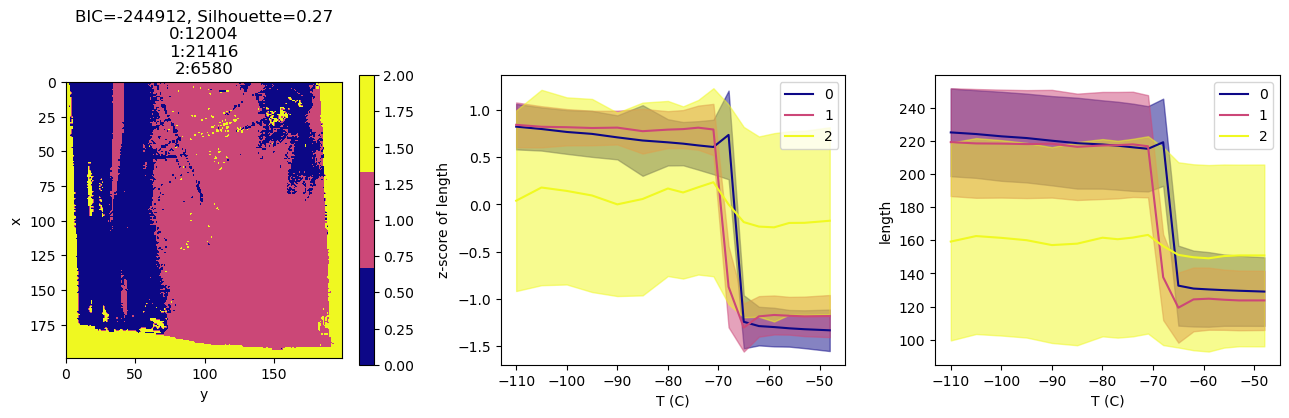

In [29]:
# all_peaks_outlier.GMM_fit('length',k=3)
all_peaks_outlier.GMM_plot('length',[0,2,1])

## all_peaks_1_outlier_thrs_3

In [30]:
all_peaks_outlier_thrs_3=GMM_model('q_Txy_all_peaks_outlier_thrs_3.pickle')

In [32]:
all_peaks_outlier_thrs_3.GMM_hypertuning_GridSearchCV('mean',trial=10)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=918924.879, test=918924.262) silhouette: (train=0.050, test=0.050) total time=  20.1s
[CV 1/1] END n_components=3; bic: (train=892824.912, test=892828.852) silhouette: (train=0.004, test=0.004) total time=  26.8s
[CV 1/1] END n_components=4; bic: (train=881924.563, test=881934.787) silhouette: (train=0.004, test=0.004) total time=  40.9s
[CV 1/1] END n_components=5; bic: (train=878168.977, test=878170.106) silhouette: (train=-0.002, test=-0.002) total time=  45.7s
[CV 1/1] END n_components=6; bic: (train=874739.580, test=875111.233) silhouette: (train=-0.004, test=0.005) total time=  53.5s


Text(0, 0.5, 'Silhouette Score')

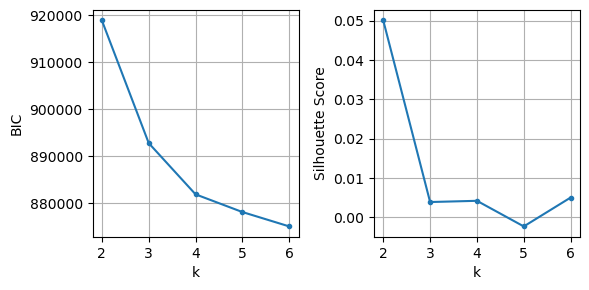

In [33]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(all_peaks_outlier_thrs_3.k_range,all_peaks_outlier_thrs_3.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(all_peaks_outlier_thrs_3.k_range,all_peaks_outlier_thrs_3.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(all_peaks_outlier_thrs_3.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

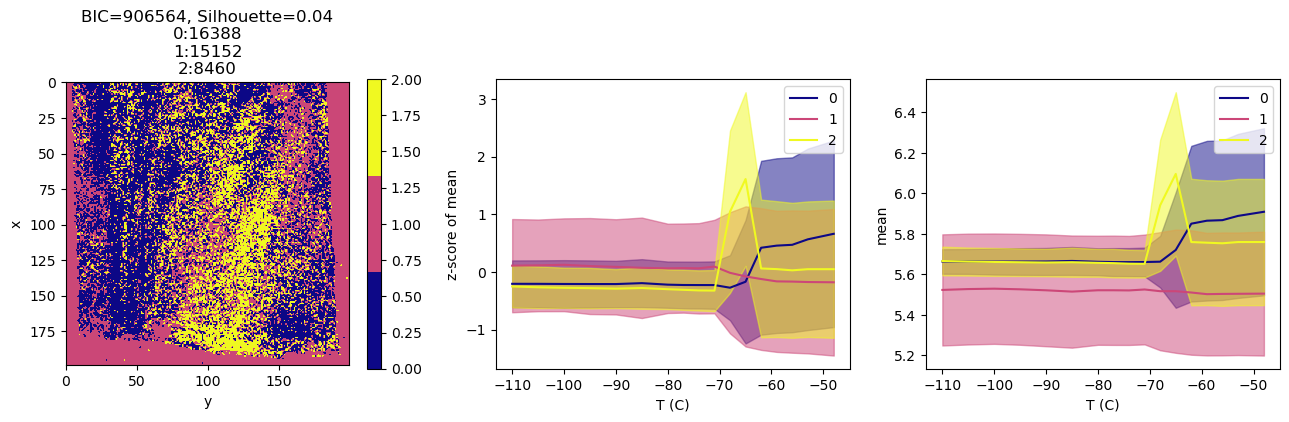

In [61]:
all_peaks_outlier_thrs_3.GMM_fit('mean',k=3)
all_peaks_outlier_thrs_3.GMM_plot('mean',)

In [34]:
all_peaks_outlier_thrs_3.GMM_hypertuning_GridSearchCV('std',trial=10)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=557266.199, test=557266.195) silhouette: (train=0.052, test=0.052) total time=  22.9s
[CV 1/1] END n_components=3; bic: (train=494488.793, test=494483.413) silhouette: (train=-0.022, test=-0.022) total time=  31.1s
[CV 1/1] END n_components=4; bic: (train=456413.698, test=456264.252) silhouette: (train=-0.025, test=-0.028) total time=  41.3s
[CV 1/1] END n_components=5; bic: (train=435793.239, test=438826.657) silhouette: (train=-0.099, test=-0.073) total time=  52.3s
[CV 1/1] END n_components=6; bic: (train=423730.618, test=423563.375) silhouette: (train=-0.090, test=-0.095) total time= 1.2min


Text(0, 0.5, 'Silhouette Score')

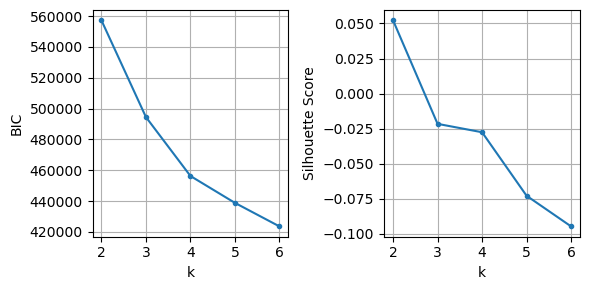

In [35]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(all_peaks_outlier_thrs_3.k_range,all_peaks_outlier_thrs_3.search['std'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(all_peaks_outlier_thrs_3.k_range,all_peaks_outlier_thrs_3.search['std'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(all_peaks_outlier_thrs_3.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

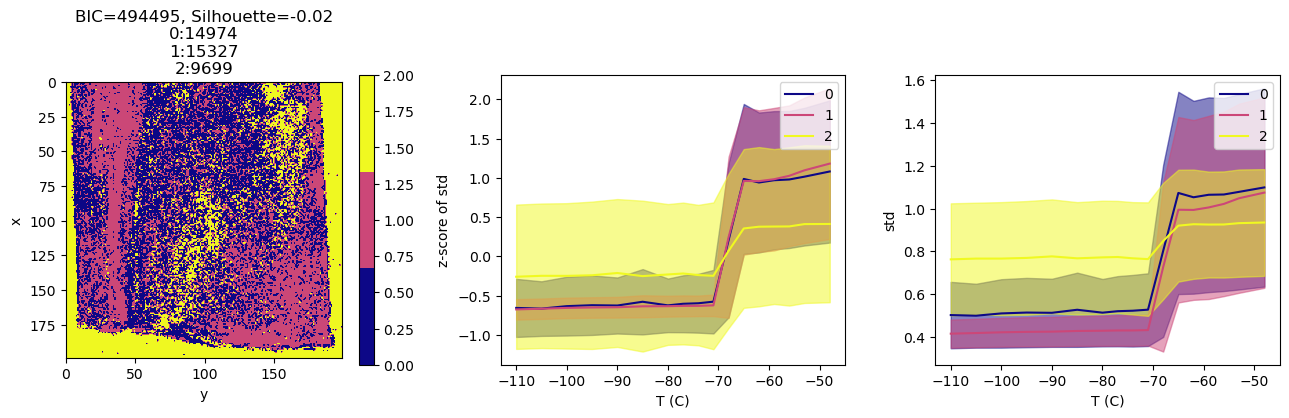

In [39]:
all_peaks_outlier_thrs_3.GMM_fit('std',k=3)
all_peaks_outlier_thrs_3.GMM_plot('std',)

In [36]:
all_peaks_outlier_thrs_3.GMM_hypertuning_GridSearchCV('length',trial=10)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=-166290.705, test=-166290.705) silhouette: (train=0.535, test=0.535) total time=  19.5s
[CV 1/1] END n_components=3; bic: (train=-225608.231, test=-225637.084) silhouette: (train=0.052, test=0.051) total time=  25.2s
[CV 1/1] END n_components=4; bic: (train=-259791.315, test=-259787.961) silhouette: (train=0.096, test=0.096) total time=  48.3s
[CV 1/1] END n_components=5; bic: (train=-284340.455, test=-284344.847) silhouette: (train=0.082, test=0.081) total time=  53.7s
[CV 1/1] END n_components=6; bic: (train=-294165.963, test=-294163.654) silhouette: (train=0.046, test=0.046) total time= 1.2min


Text(0, 0.5, 'Silhouette Score')

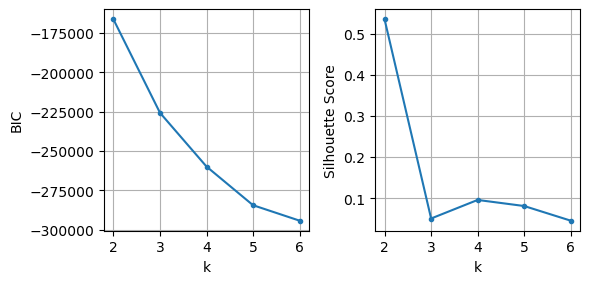

In [37]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(all_peaks_outlier_thrs_3.k_range,all_peaks_outlier_thrs_3.search['length'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(all_peaks_outlier_thrs_3.k_range,all_peaks_outlier_thrs_3.search['length'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(all_peaks_outlier_thrs_3.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

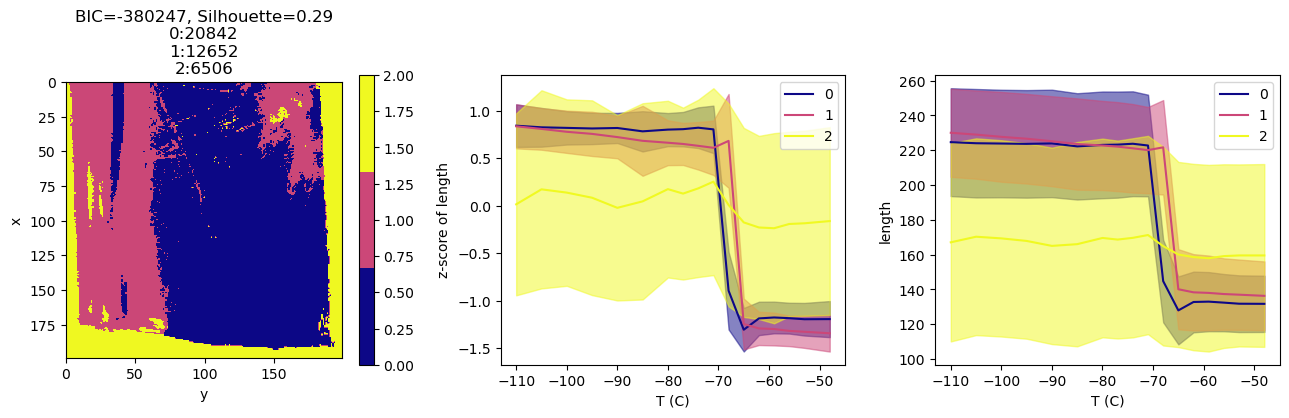

In [40]:
all_peaks.GMM_fit('length',k=3)
all_peaks.GMM_plot('length',[1,0,2])

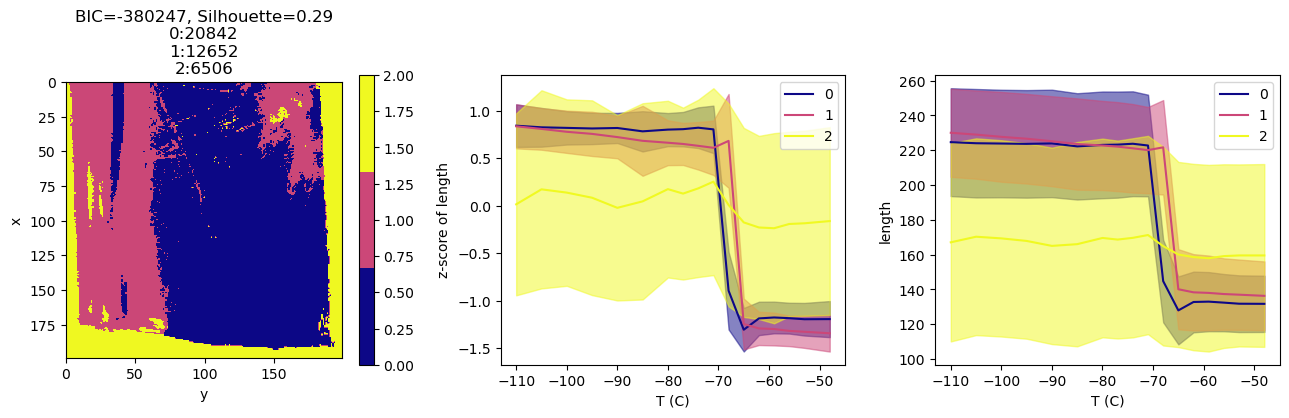

In [60]:
all_peaks.GMM_fit('length',k=3)
all_peaks.GMM_plot('length',[1,0,2])

## count_pts_1

In [2]:
count_pts=GMM_model('q_Txy_count_pts_1.pickle',)

In [18]:
count_pts.GMM_hypertuning_GridSearchCV('mean')

Fitting 1 folds for each of 5 candidates, totalling 5 fits


Text(0, 0.5, 'Silhouette Score')

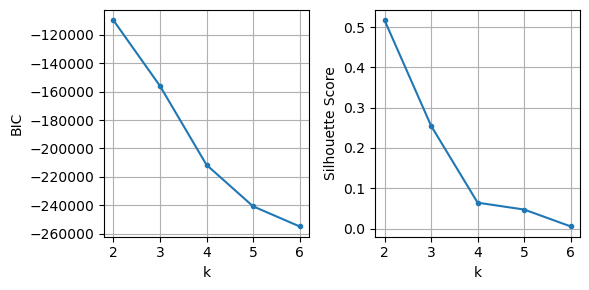

[CV 1/1] END n_components=2; bic: (train=-109692.000, test=-109692.000) silhouette: (train=0.517, test=0.517) total time=  19.8s
[CV 1/1] END n_components=3; bic: (train=-181077.555, test=-155960.650) silhouette: (train=0.027, test=0.255) total time=  24.3s
[CV 1/1] END n_components=4; bic: (train=-211588.124, test=-211588.799) silhouette: (train=0.064, test=0.064) total time=  46.1s


In [19]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts.k_range,count_pts.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts.k_range,count_pts.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

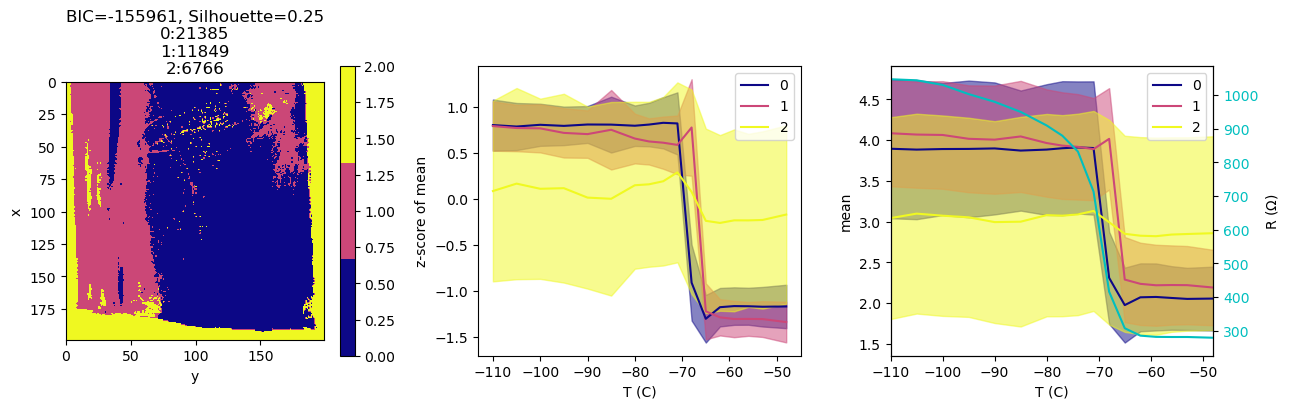

In [21]:
count_pts.GMM_fit('mean',k=3)
fig,ax=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts.GMM_plot('mean',[0,2,1],ax=ax)

ax2=ax[2].twinx()
ax2.plot(T,R,'c')
ax2.set_xlim(count_pts.rs['T'][0],count_pts.rs['T'][-1])
ax2.set_ylabel('R ($\Omega$)')
ax2.tick_params(axis='y', labelcolor='c')

In [7]:
count_pts.GMM_hypertuning_GridSearchCV('std')

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=1073841.161, test=1073841.116) silhouette: (train=0.145, test=0.145) total time=  21.5s
[CV 1/1] END n_components=3; bic: (train=1057786.042, test=1057786.182) silhouette: (train=0.112, test=0.112) total time=  26.9s
[CV 1/1] END n_components=4; bic: (train=1057866.593, test=1057865.047) silhouette: (train=0.117, test=0.117) total time=  30.5s
[CV 1/1] END n_components=5; bic: (train=1045249.145, test=1045271.750) silhouette: (train=0.012, test=0.012) total time=  41.3s


Text(0, 0.5, 'Silhouette Score')

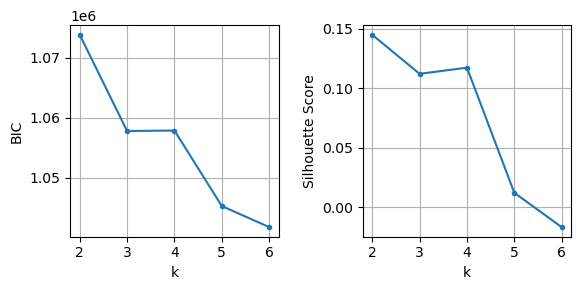

In [8]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts.k_range,count_pts.search['std'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts.k_range,count_pts.search['std'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

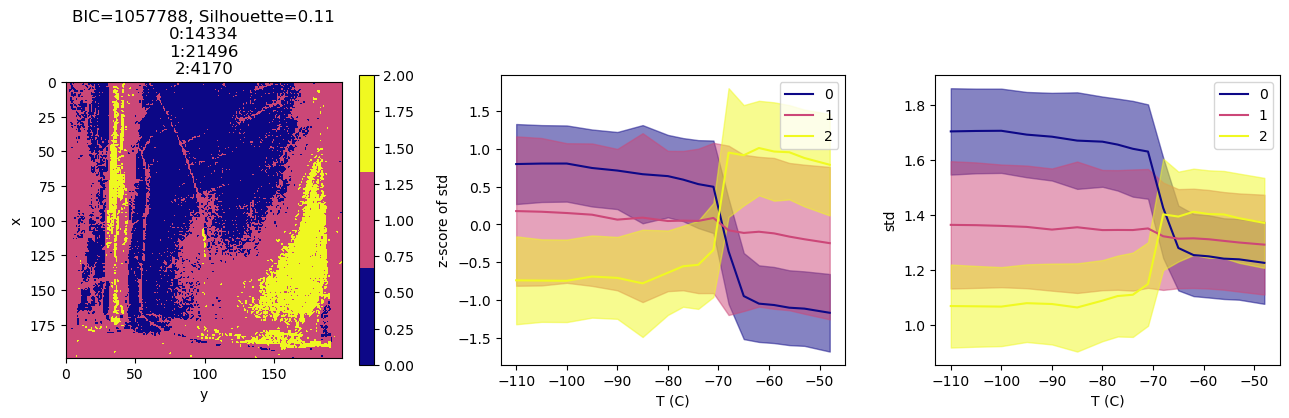

In [10]:
count_pts.GMM_fit('std',k=3)
count_pts.GMM_plot('std',[0,2,1])

## count_pts_outlier

In [4]:
count_pts_outlier=GMM_model('q_Txy_count_pts_outlier_1.pickle',)

In [13]:
count_pts_outlier.GMM_hypertuning_GridSearchCV('mean')

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=-150450.753, test=-150450.753) silhouette: (train=0.532, test=0.532) total time=  19.9s
[CV 1/1] END n_components=3; bic: (train=-205933.147, test=-205930.396) silhouette: (train=0.090, test=0.090) total time=  24.0s
[CV 1/1] END n_components=4; bic: (train=-239190.875, test=-239194.718) silhouette: (train=0.157, test=0.157) total time=  44.2s
[CV 1/1] END n_components=5; bic: (train=-264704.611, test=-264696.245) silhouette: (train=0.064, test=0.064) total time=  58.8s
[CV 1/1] END n_components=6; bic: (train=-272756.993, test=-279712.300) silhouette: (train=0.049, test=0.008) total time= 1.3min


Text(0, 0.5, 'Silhouette Score')

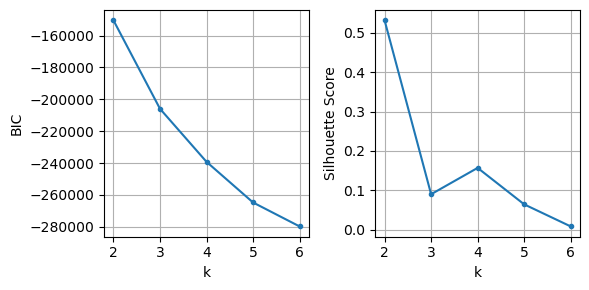

In [14]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_outlier.k_range,count_pts_outlier.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_outlier.k_range,count_pts_outlier.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_outlier.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

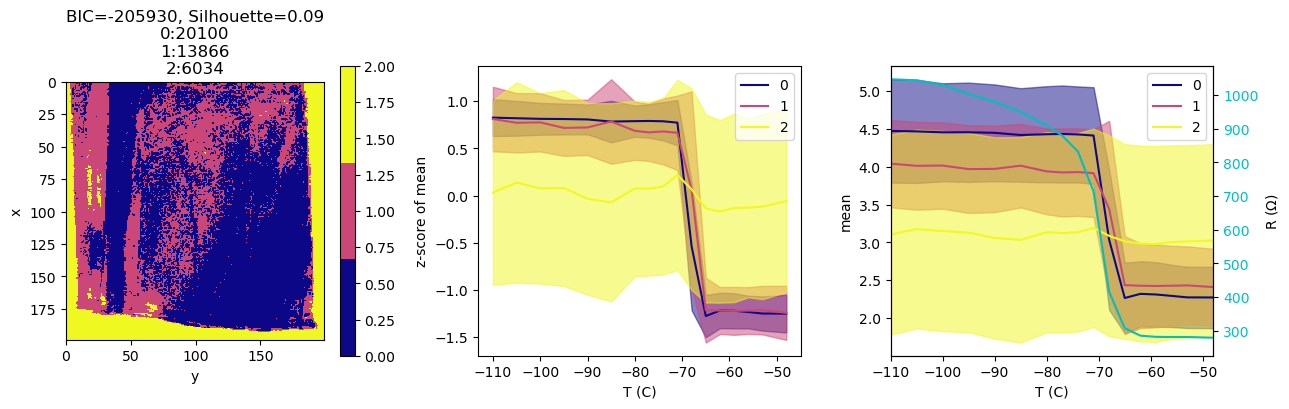

In [49]:
# count_pts_outlier.GMM_fit('mean',k=3)
fig,ax=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts_outlier.GMM_plot('mean',[0,2,1],ax=ax)

ax2=ax[2].twinx()
ax2.plot(T,R,'c')
ax2.set_xlim(count_pts_outlier.rs['T'][0],count_pts_outlier.rs['T'][-1])
ax2.set_ylabel('R ($\Omega$)')
ax2.tick_params(axis='y', labelcolor='c')


In [15]:
count_pts_outlier.GMM_hypertuning_GridSearchCV('std')

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=3; bic: (train=1231881.655, test=1231881.392) silhouette: (train=0.048, test=0.048) total time=  29.1s
[CV 1/1] END n_components=4; bic: (train=1232659.665, test=1232656.725) silhouette: (train=0.063, test=0.063) total time=  29.9s
[CV 1/1] END n_components=2; bic: (train=1251037.859, test=1251037.935) silhouette: (train=0.082, test=0.082) total time=  30.8s
[CV 1/1] END n_components=5; bic: (train=1228787.541, test=1228787.737) silhouette: (train=0.016, test=0.016) total time=  37.8s
[CV 1/1] END n_components=6; bic: (train=1229190.295, test=1229222.758) silhouette: (train=0.014, test=0.014) total time=  48.4s


Text(0, 0.5, 'Silhouette Score')

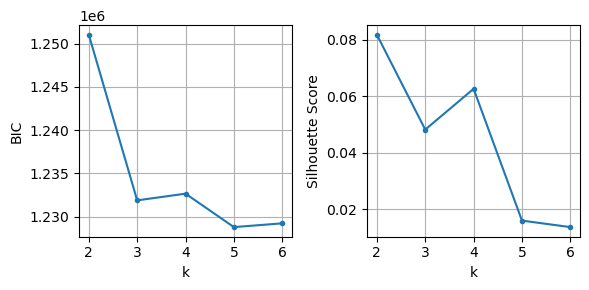

In [16]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_outlier.k_range,count_pts_outlier.search['std'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_outlier.k_range,count_pts_outlier.search['std'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_outlier.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

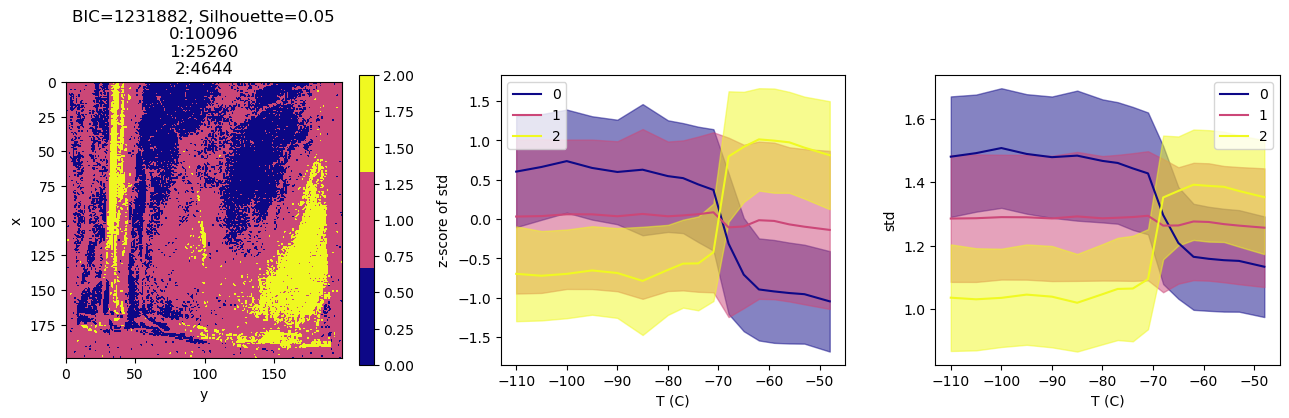

In [22]:
# count_pts_outlier.GMM_fit('std',k=3)
count_pts_outlier.GMM_plot('std',[1,0,2])

## count_pts_2

In [6]:
count_pts_2=GMM_model('q_Txy_count_pts_2.pickle',)

In [7]:
count_pts_2.GMM_hypertuning_GridSearchCV('mean')

Fitting 1 folds for each of 5 candidates, totalling 5 fits


Text(0, 0.5, 'Silhouette Score')

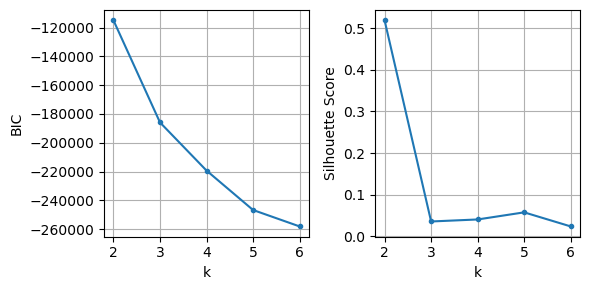

In [8]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_2.k_range,count_pts_2.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_2.k_range,count_pts_2.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_2.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

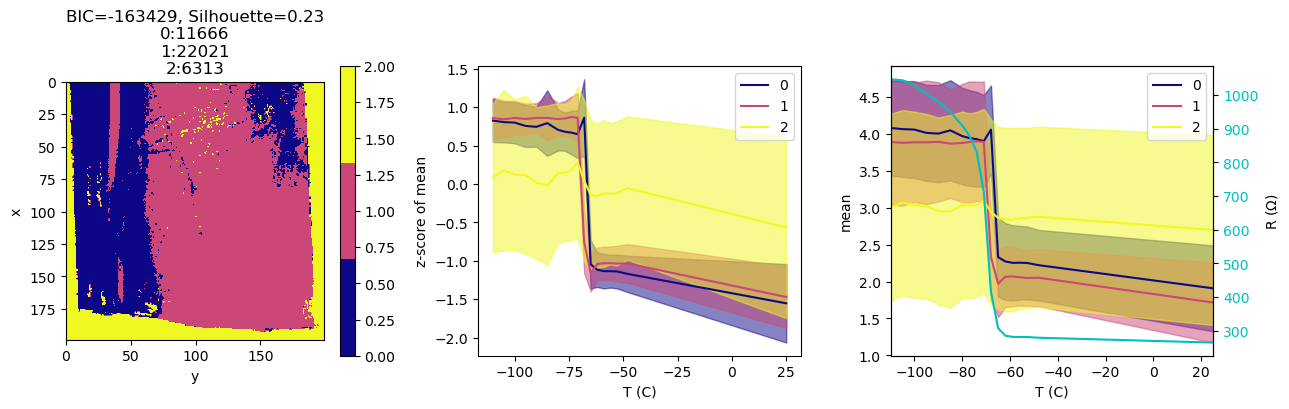

In [16]:
count_pts_2.GMM_fit('mean',k=3)
fig,ax=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts_2.GMM_plot('mean',[0,2,1],ax=ax)

ax2=ax[2].twinx()
ax2.plot(T,R,'c')
ax2.set_xlim(count_pts_2.rs['T'][0],count_pts_2.rs['T'][-1])
ax2.set_ylabel('R ($\Omega$)')
ax2.tick_params(axis='y', labelcolor='c')

In [10]:
count_pts_2.GMM_hypertuning_GridSearchCV('std')

Fitting 1 folds for each of 5 candidates, totalling 5 fits


Text(0, 0.5, 'Silhouette Score')

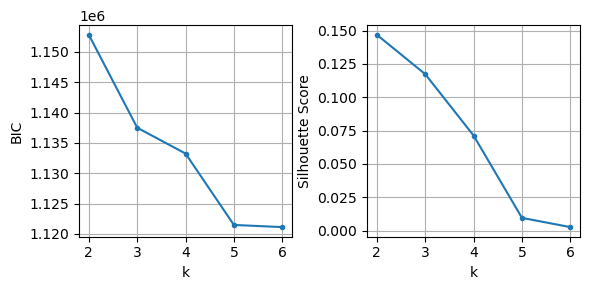

In [11]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_2.k_range,count_pts_2.search['std'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_2.k_range,count_pts_2.search['std'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_2.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

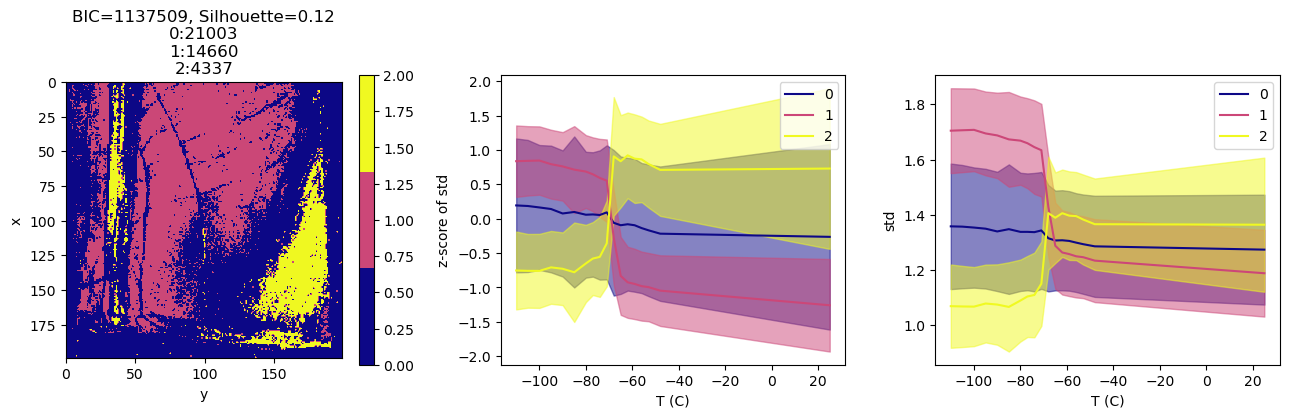

In [12]:
count_pts_2.GMM_fit('std',k=3)
count_pts_2.GMM_plot('std',[0,2,1])

## count_pts_outlier

In [13]:
count_pts_outlier_2=GMM_model('q_Txy_count_pts_outlier_2.pickle',)

In [ ]:
count_pts_outlier_2.GMM_hypertuning_GridSearchCV('mean')

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_outlier_2.k_range,count_pts_outlier_2.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_outlier_2.k_range,count_pts_outlier_2.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_outlier_2.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
count_pts_outlier_2.GMM_fit('mean',k=3)
fig,ax=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts_outlier_2.GMM_plot('mean',[0,2,1],ax=ax)

ax2=ax[2].twinx()
ax2.plot(T,R,'c')
ax2.set_xlim(count_pts_outlier_2.rs['T'][0],count_pts_outlier_2.rs['T'][-1])
ax2.set_ylabel('R ($\Omega$)')
ax2.tick_params(axis='y', labelcolor='c')


In [ ]:
count_pts_outlier_2.GMM_hypertuning_GridSearchCV('std')

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_outlier_2.k_range,count_pts_outlier_2.search['std'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_outlier_2.k_range,count_pts_outlier_2.search['std'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_outlier_2.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
count_pts_outlier_2.GMM_fit('std',k=3)
count_pts_outlier_2.GMM_plot('std',[1,0,2])

## Homogeneous region

In [47]:
mask=((120,160),(60,100))

In [48]:
all_peaks_subset=GMM_model('q_Txy_all_peaks_1.pickle',mask=mask)

In [59]:
all_peaks_subset.GMM_hypertuning_GridSearchCV('mean')

Text(0, 0.5, 'Silhouette Score')

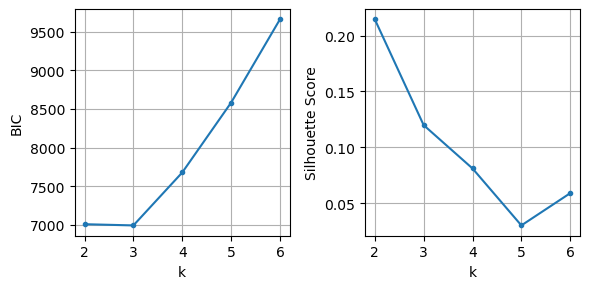

In [60]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(all_peaks_subset.k_range,all_peaks_subset.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(all_peaks_subset.k_range,all_peaks_subset.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(all_peaks_subset.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

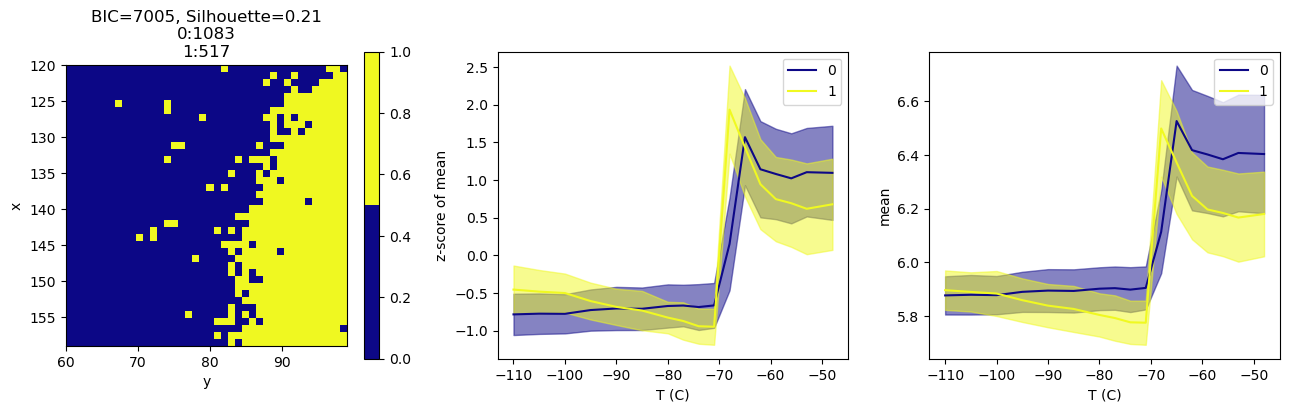

In [61]:
all_peaks_subset.GMM_fit('mean',k=2)
all_peaks_subset.GMM_plot('mean')

### count_pts_1_subset

In [53]:
count_pts_subet=GMM_model('q_Txy_count_pts_1.pickle',mask=mask)

In [54]:
count_pts_subet.GMM_hypertuning_GridSearchCV('mean')

Fitting 1 folds for each of 5 candidates, totalling 5 fits


Text(0, 0.5, 'Silhouette Score')

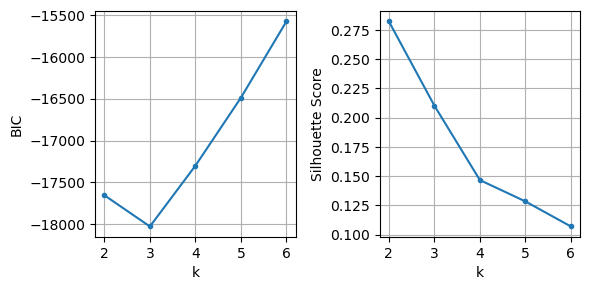

In [62]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_subet.k_range,count_pts_subet.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_subet.k_range,count_pts_subet.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_subet.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

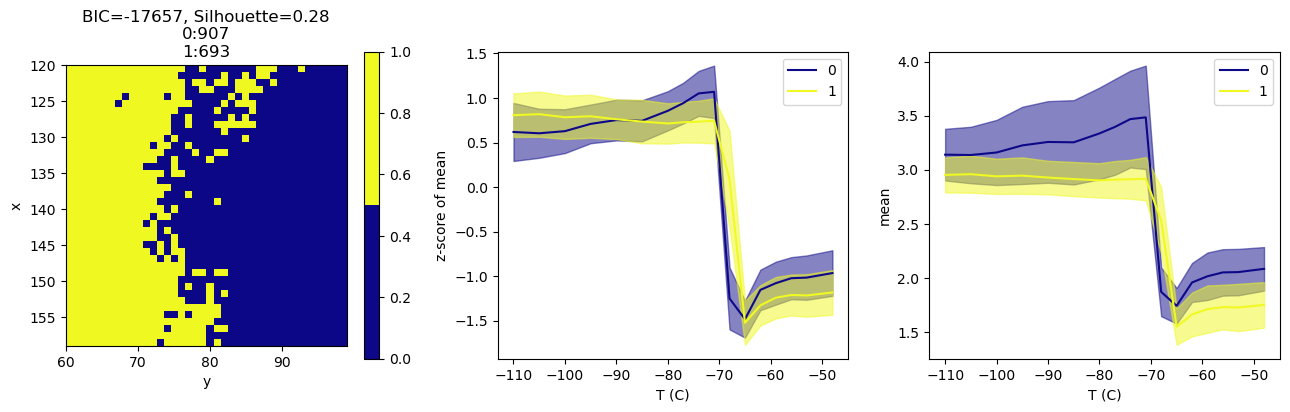

In [63]:
count_pts_subet.GMM_fit('mean',k=2)
count_pts_subet.GMM_plot('mean')

### count_pts_1_outlet_subset

In [66]:
count_pts_outlier_subset=GMM_model('q_Txy_count_pts_outlier_1.pickle',mask=mask)

In [67]:
count_pts_outlier_subset.GMM_hypertuning_GridSearchCV('mean')

Fitting 1 folds for each of 5 candidates, totalling 5 fits


Text(0, 0.5, 'Silhouette Score')

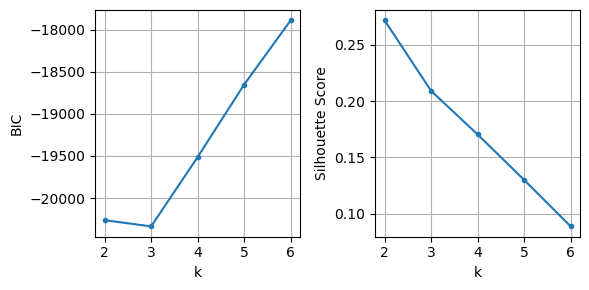

In [68]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_outlier_subset.k_range,count_pts_outlier_subset.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_outlier_subset.k_range,count_pts_outlier_subset.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_outlier_subset.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

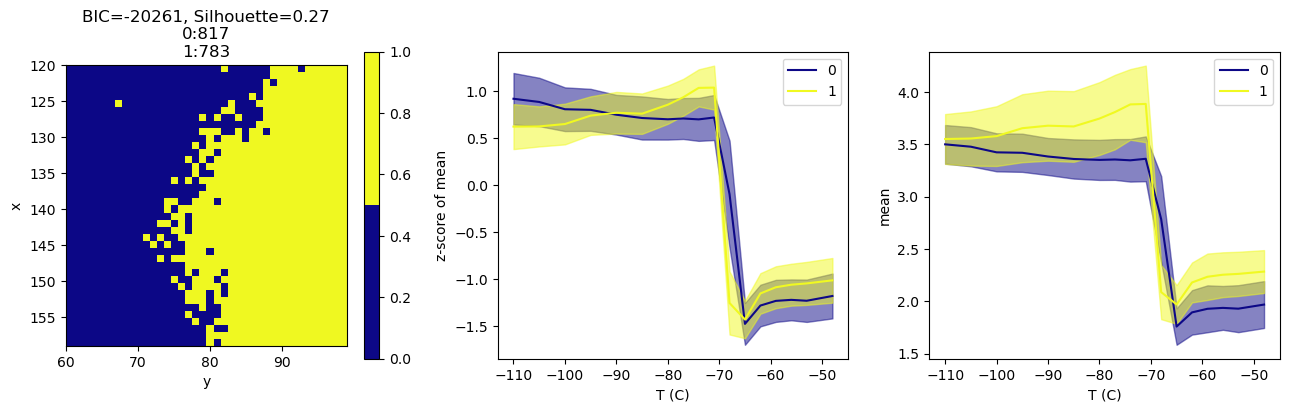

[CV 1/1] END n_components=4; bic: (train=-17298.502, test=-17301.896) silhouette: (train=0.146, test=0.147) total time=   0.6s
[CV 1/1] END n_components=3; bic: (train=-20335.184, test=-20335.204) silhouette: (train=0.209, test=0.209) total time=   0.4s
[CV 1/1] END n_components=2; bic: (train=-17656.638, test=-17656.638) silhouette: (train=0.282, test=0.282) total time=   0.3s
[CV 1/1] END n_components=3; bic: (train=-18030.695, test=-18030.695) silhouette: (train=0.210, test=0.210) total time=   0.5s
[CV 1/1] END n_components=5; bic: (train=-16484.417, test=-16486.494) silhouette: (train=0.129, test=0.128) total time=   0.7s
[CV 1/1] END n_components=6; bic: (train=-15597.944, test=-15571.148) silhouette: (train=0.102, test=0.107) total time=   0.9s
[CV 1/1] END n_components=6; bic: (train=-17753.686, test=-17822.409) silhouette: (train=0.096, test=0.092) total time=   1.1s
[CV 1/1] END n_components=2; bic: (train=-20260.950, test=-20260.920) silhouette: (train=0.271, test=0.272) tot

In [70]:
count_pts_outlier_subset.GMM_fit('mean',k=2)
count_pts_outlier_subset.GMM_plot('mean')

# Dataset 2

## Raw data

In [3]:
import h5py

In [4]:
workingdir='/share/kim/STEM_sample_2/'
f=h5py.File(workingdir+'data.hdf5','r')
I,T=f['I'],f['T']

In [5]:
def generate_ave_figure(I,fit_model,T_idx_max=None,filename=None,movie=False,figure=False,array=False):
    if T_idx_max is None:
        T_idx_max=I.shape[0]
    ij=fit_model.ij
    T_list=fit_model.rs['T']
    num_clusters=fit_model.k
    if -1 in ij.keys():
        cluster_list=list(range(num_clusters))+[-1]
    else:
        cluster_list=list(range(num_clusters))
    I_ave_cluster={}
    T_idx_list=np.arange(T_idx_max)
    for cluster_idx,cluster in enumerate(cluster_list):
        print(f'{cluster}')
        I_cluster=np.array([I[T_idx_list,i,j,:,:] for i,j in ij[cluster]]).mean(axis=0)
        I_ave_cluster[cluster]=I_cluster
    if figure:
        fig,axs=plt.subplots(T_idx_max,len(cluster_list),figsize=(15,3*T_idx_max),tight_layout=True)
    if array:
        data_store={}
    for T_idx in range(T_idx_max):
        for cluster_idx,cluster in enumerate(cluster_list):
            data=I_ave_cluster[cluster][T_idx]
            if array:
                if cluster!=-1:
                    data_store[(cluster,T_list[T_idx])]=data
            if figure:
                ax=axs[T_idx,cluster_idx]
                vmin,vmax=data.min(),data.max()
                im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
                tit=ax.set_title('T={:d} K'.format(T_list[T_idx]))
                ax.set_xlabel(r'$k_x$')
                ax.set_ylabel(r'$k_y$')
        
    if filename is not None:
        if figure:
            fig.savefig(f'{filename}.png')
        if array:
            with open(f'{filename}.pickle','wb') as f:
                pickle.dump(data_store,f)

    if movie:
        fig_mp4,axs=plt.subplots(1,len(cluster_list),figsize=(15,3),tight_layout=True)
        T_idx=0
        im=[]
        tit=[]
        for cluster_idx,cluster in enumerate(cluster_list):
            ax=axs[cluster_idx]
            data=I_ave_cluster[cluster][T_idx]
            vmin,vmax=data.min(),data.max()
            im.append(ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax)))
            tit.append(ax.set_title('T={:d} K'.format(T_list[T_idx])))
            cluster_text='Vacuum' if cluster==-1 else f'Cluster {cluster}'
            ax.text(0,1,cluster_text,ha='right',va='bottom',transform=ax.transAxes)
            
            ax.set_xlabel(r'$k_x$')
            ax.set_ylabel(r'$k_y$')
        
        def animate(i):
            for cluster_idx,cluster in enumerate(cluster_list):
                data=I_ave_cluster[cluster][i]
                im[cluster_idx].set_array(data)
                tit[cluster_idx].set_text('T={:d} K'.format(T_list[i]))
            return im+tit

        anim = FuncAnimation(fig_mp4, animate, interval=1000, frames=T_idx_max,blit=True,repeat=True)
        anim.save(f'{filename}.mp4',dpi=300)





    # for T_idx in range(T_idx_max):
    #     for cluster_idx,cluster in enumerate(cluster_list):
    #         I_cluster=np.array([I[T_idx,i,j,:,:] for i,j in ij[cluster]])
    #         data=I_cluster.mean(axis=0)
    #         vmin,vmax=data.min(),data.max()
    #         ax=axs[T_idx,cluster_idx]
    #         im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    #         tit=ax.set_title('T={:d} K'.format(T_list[T_idx]))
    #         # cb=plt.colorbar(im)
    #         # cb.ax.set_title(r'$ I(k_x,k_y) $')
    #         ax.set_xlabel(r'$k_x$')
    #         ax.set_ylabel(r'$k_y$')

## Transport

In [6]:
cond=np.load(workingdir+'/RvT.npy')
cond_K=cond+np.array([273,0])

In [7]:
def generate_mask_line(x,y):
    '''
    x: (min,max)
    y: (min,max)
    '''
    i_idx,j_idx=np.meshgrid(np.arange(200),np.arange(200),indexing='ij')
    x_min,x_max=x
    y_min,y_max=y
    return (i_idx<((y_max-y_min)/(x_max-x_min)*j_idx+y_min))

In [8]:
mask=generate_mask_line((0,81), (178,199))
# mask=generate_mask_line((0,81), (192,199))

## count_pts_sample_2

In [1]:
count_pts_sample_2=GMM_model('q_Txy_count_pts_sample_2.pickle',mask=mask)

NameError: name 'GMM_model' is not defined

In [30]:
count_pts_sample_2.GMM_hypertuning_GridSearchCV('mean')

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=1325314.655, test=1325314.655) silhouette: (train=0.175, test=0.175) total time=  45.2s
[CV 1/1] END n_components=3; bic: (train=1278830.496, test=1278830.586) silhouette: (train=0.005, test=0.005) total time= 1.7min
[CV 1/1] END n_components=4; bic: (train=1258159.676, test=1258159.554) silhouette: (train=-0.027, test=-0.027) total time= 2.2min
[CV 1/1] END n_components=5; bic: (train=1244376.352, test=1244350.912) silhouette: (train=-0.008, test=-0.010) total time= 3.0min
[CV 1/1] END n_components=6; bic: (train=1234228.818, test=1235124.050) silhouette: (train=-0.034, test=-0.017) total time= 3.9min


Text(0, 0.5, 'Silhouette Score')

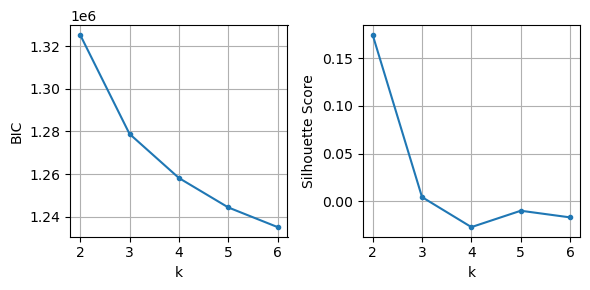

In [31]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_sample_2.k_range,count_pts_sample_2.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_sample_2.k_range,count_pts_sample_2.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_sample_2.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

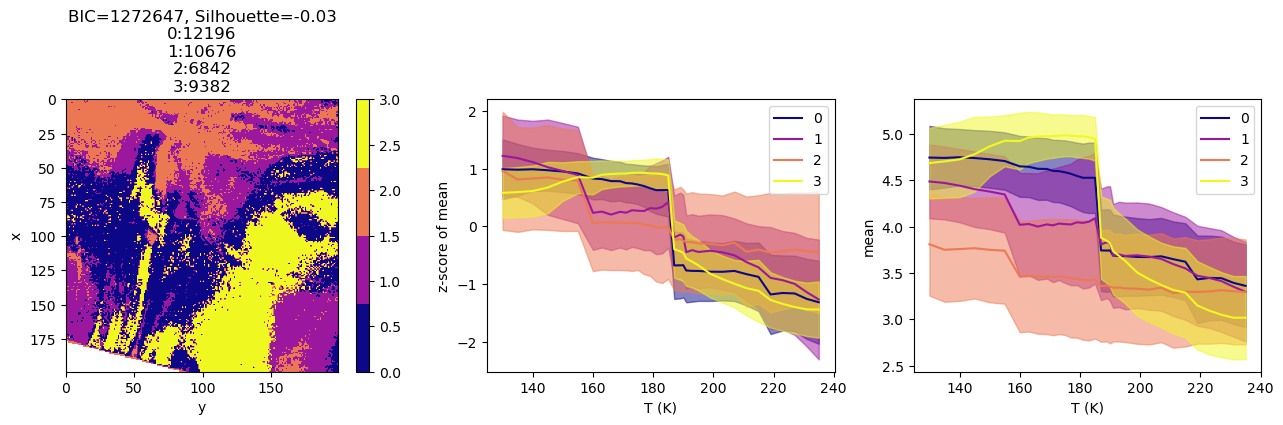

In [ ]:
count_pts_sample_2.GMM_fit('mean',k=4)
fig,ax=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts_sample_2.GMM_plot('mean',[0,1,2,3],ax=ax)

# ax[0].plot([0,90],[175,199],color='k',ls='dotted')
# ax2=ax[2].twinx()
# ax2.plot(cond[:,0],cond[:,1],'c')
# ax2.set_xlim(count_pts_sample_2.rs['T'][0],count_pts_sample_2.rs['T'][-1])
# ax2.set_ylabel('R ($\Omega$)')
# ax2.tick_params(axis='y', labelcolor='c')

# ax[0].axvline(x=25)
# ax[0].axhline(y=185)

In [ ]:
count_pts_sample_2.convert_real_space('mean')

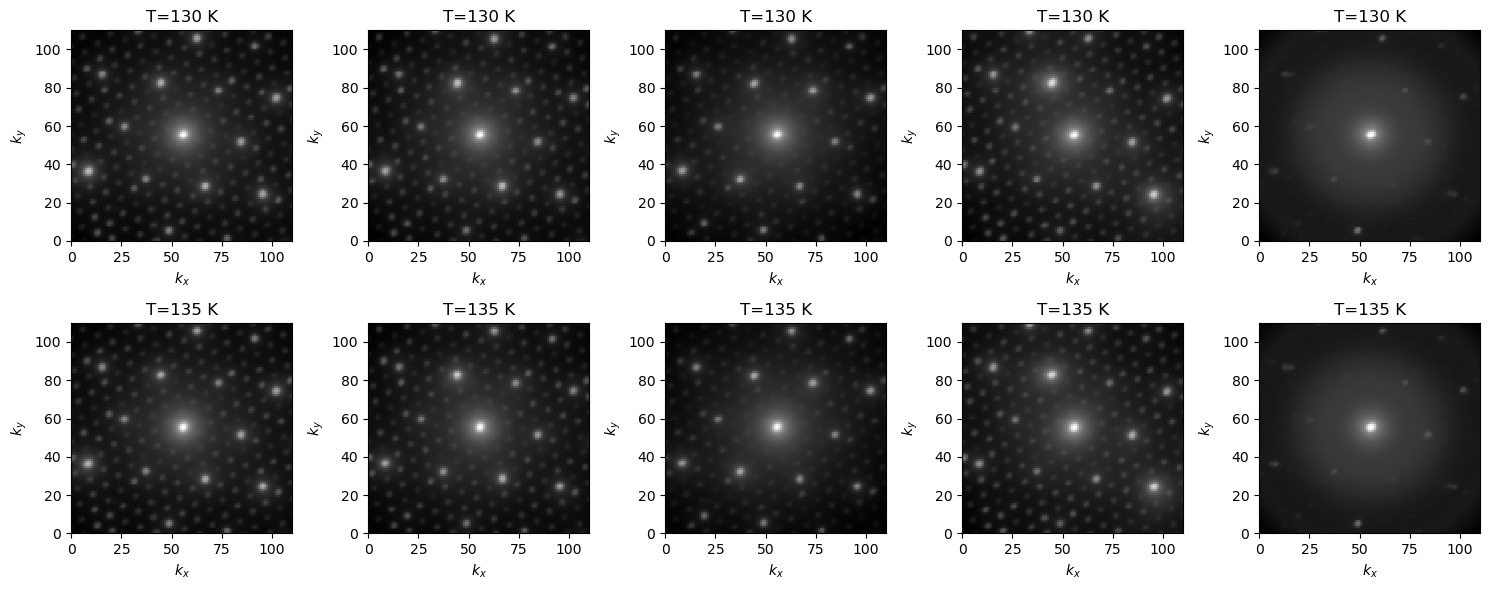

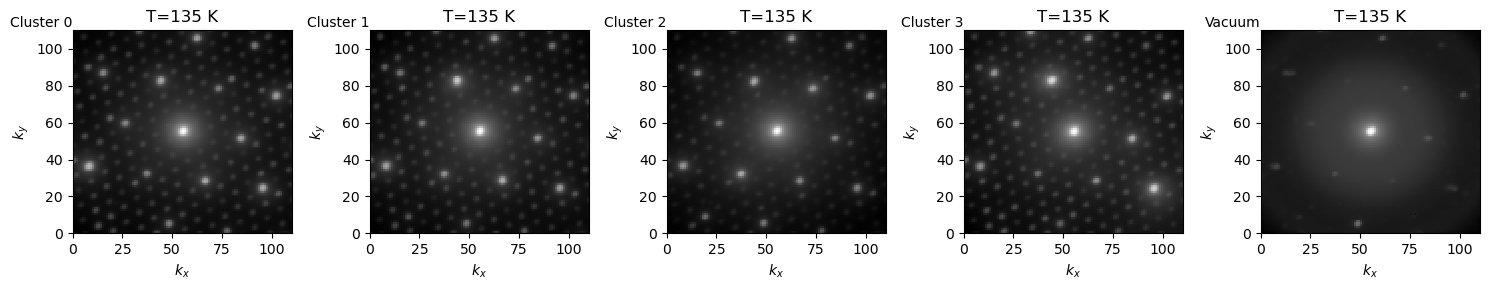

In [121]:
generate_ave_figure(I, fit_model=count_pts_sample_2,T_idx_max=2,filename='ave_cluster_real_space',movie=True)

Text(0, 0.5, '$k_y$')

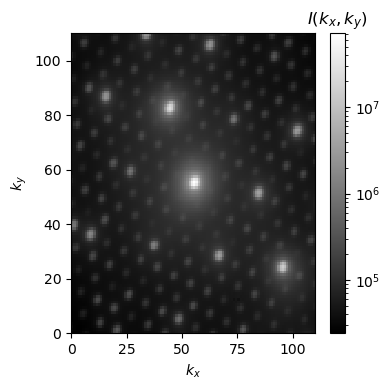

In [76]:
fig,ax=plt.subplots(figsize=(4,4),tight_layout=True)

vmin,vmax=data.min(),data.max()
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title(r'$ I(k_x,k_y) $')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')

Text(0, 0.5, '$k_y$')

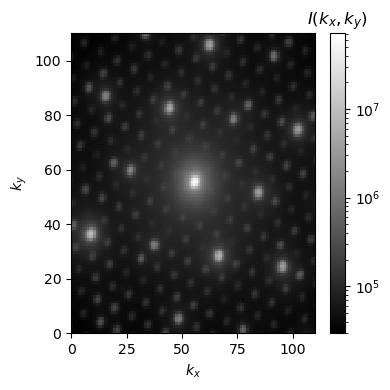

In [80]:
fig,ax=plt.subplots(figsize=(4,4),tight_layout=True)

vmin,vmax=data.min(),data.max()
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title(r'$ I(k_x,k_y) $')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')

Text(0, 0.5, '$k_y$')

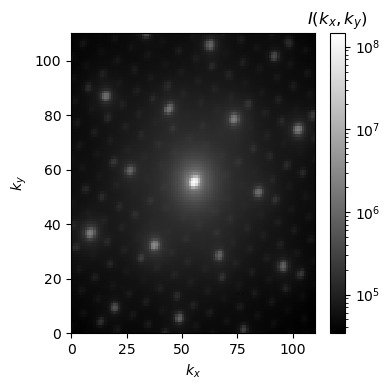

In [86]:
fig,ax=plt.subplots(figsize=(4,4),tight_layout=True)

vmin,vmax=data.min(),data.max()
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title(r'$ I(k_x,k_y) $')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')

Text(0, 0.5, '$k_y$')

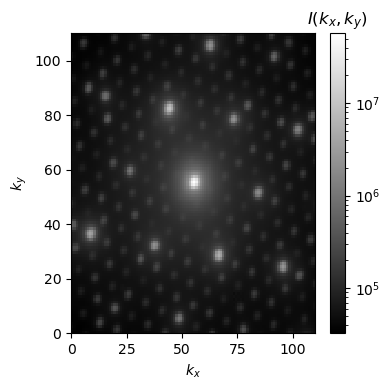

In [89]:
fig,ax=plt.subplots(figsize=(4,4),tight_layout=True)

vmin,vmax=data.min(),data.max()
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title(r'$ I(k_x,k_y) $')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')

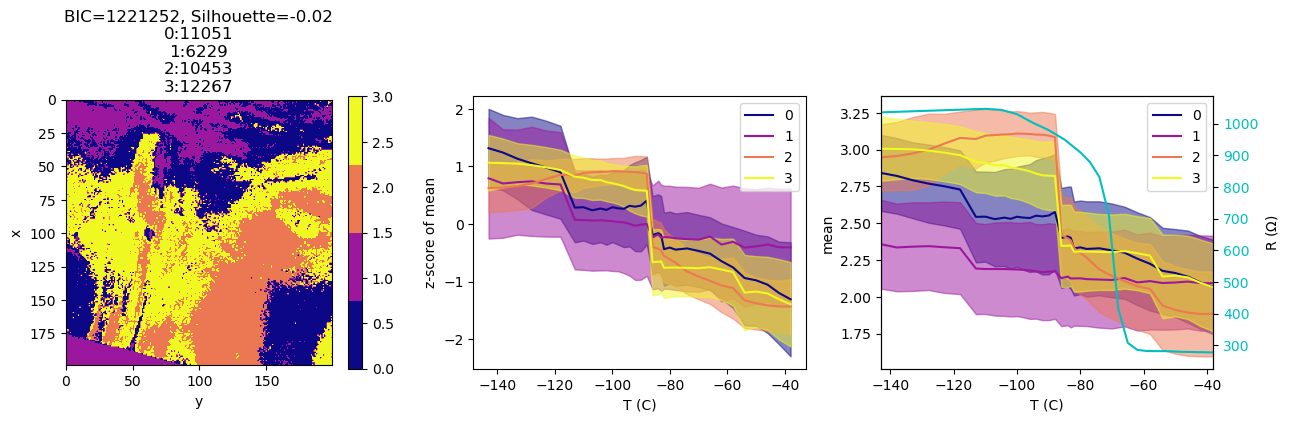

In [ ]:
count_pts_sample_2.GMM_fit('mean',k=4)
fig,ax=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts_sample_2.GMM_plot('mean',[0,2,1,3],ax=ax)

ax2=ax[2].twinx()
ax2.plot(T,R,'c')
ax2.set_xlim(count_pts_sample_2.rs['T'][0],count_pts_sample_2.rs['T'][-1])
ax2.set_ylabel('R ($\Omega$)')
ax2.tick_params(axis='y', labelcolor='c')

In [13]:
count_pts_sample_2.GMM_hypertuning_GridSearchCV('std')

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=3059242.138, test=3059242.556) silhouette: (train=0.068, test=0.068) total time= 1.0min
[CV 1/1] END n_components=3; bic: (train=3059944.630, test=3059945.095) silhouette: (train=0.029, test=0.029) total time= 1.7min
[CV 1/1] END n_components=4; bic: (train=3062261.434, test=3062218.462) silhouette: (train=0.017, test=0.017) total time= 1.9min
[CV 1/1] END n_components=5; bic: (train=3061939.110, test=3061922.431) silhouette: (train=0.006, test=0.006) total time= 4.1min
[CV 1/1] END n_components=6; bic: (train=3064894.381, test=3064902.258) silhouette: (train=-0.004, test=-0.002) total time= 4.0min


Text(0, 0.5, 'Silhouette Score')

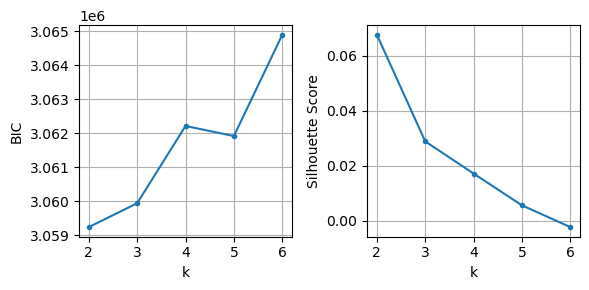

In [14]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_sample_2.k_range,count_pts_sample_2.search['std'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_sample_2.k_range,count_pts_sample_2.search['std'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_sample_2.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

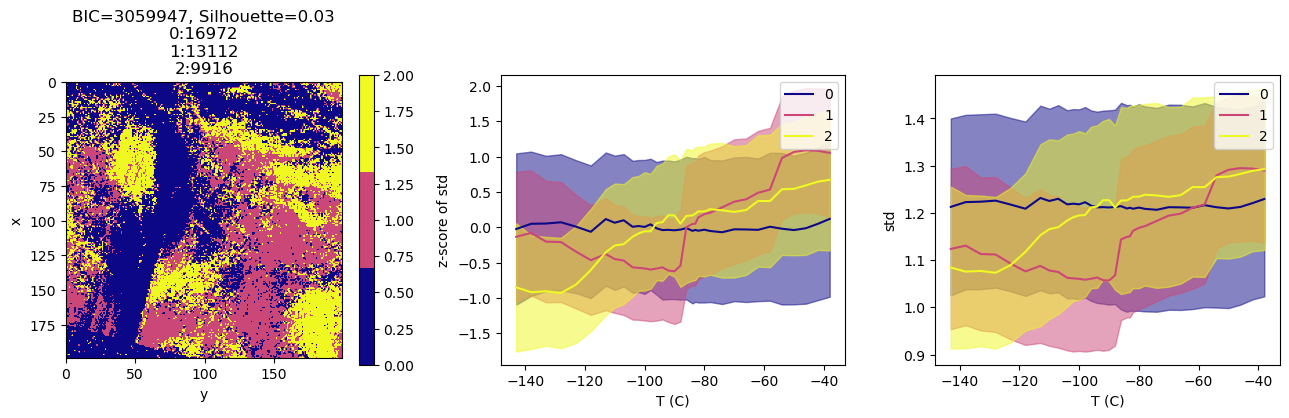

In [16]:
count_pts_sample_2.GMM_fit('std',k=3)
count_pts_sample_2.GMM_plot('std',[0,2,1])

## count_pts_outlier

In [9]:
count_pts_outlier_sample_2=GMM_model('q_Txy_count_pts_outlier_sample_2_auto_bragg.pickle',mask=mask)

In [ ]:
count_pts_outlier_sample_2.GMM_hypertuning_GridSearchCV('mean')

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END n_components=2; bic: (train=1657690.746, test=1657690.746) silhouette: (train=0.152, test=0.152) total time=  40.4s
[CV 1/1] END n_components=3; bic: (train=1624165.275, test=1624167.908) silhouette: (train=0.005, test=0.005) total time= 1.5min
[CV 1/1] END n_components=4; bic: (train=1607810.617, test=1607810.041) silhouette: (train=-0.032, test=-0.032) total time= 1.9min
[CV 1/1] END n_components=5; bic: (train=1596061.194, test=1596069.268) silhouette: (train=-0.043, test=-0.044) total time= 2.9min
[CV 1/1] END n_components=6; bic: (train=1588878.903, test=1588879.905) silhouette: (train=-0.037, test=-0.037) total time= 3.7min


Text(0, 0.5, 'Silhouette Score')

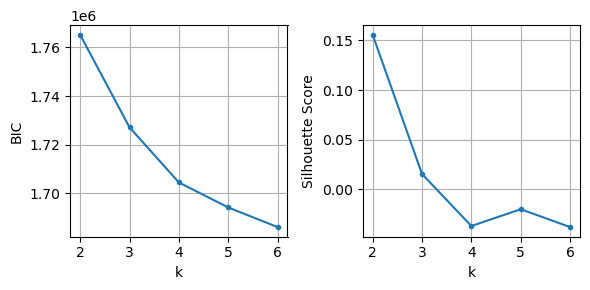

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_outlier_sample_2.k_range,count_pts_outlier_sample_2.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_outlier_sample_2.k_range,count_pts_outlier_sample_2.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_outlier_sample_2.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

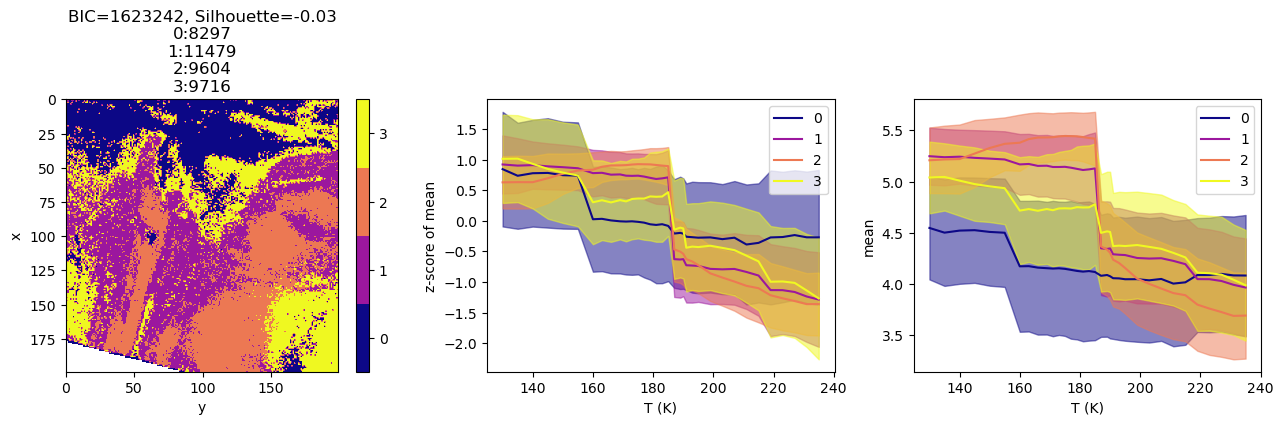

In [16]:
# count_pts_outlier_sample_2.GMM_fit('mean',k=4)
fig,ax=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts_outlier_sample_2.GMM_plot('mean',[0,1,2,3],ax=ax)

# ax2=ax[2].twinx()
# ax2.plot(cond[:,0],cond[:,1],'k')
# ax2.set_xlim(count_pts_outlier_sample_2.rs['T'][0],count_pts_outlier_sample_2.rs['T'][-1])
# ax2.set_ylabel('R ($\Omega$)')
# ax2.tick_params(axis='y', labelcolor='c')

In [13]:
with open('count_pts_outlier.pickle','wb') as f:
    pickle.dump(count_pts_outlier_sample_2,f)

In [15]:
with open('count_pts_outlier.pickle','rb') as f:
    count_pts_outlier_sample_2=pickle.load(f)

In [ ]:
generate_ave_figure(I, fit_model=count_pts_sample_2,T_idx_max=2,filename='ave_cluster_real_space',movie=True)

In [17]:
count_pts_outlier_sample_2.X_orig['mean'].shape

(39096, 34)

In [28]:
count_pts_outlier_sample_2.X_orig['mean'][:100].shape

(100, 34)

In [26]:
count_pts_outlier_sample_2.labels_['mean'].shape

(39096,)

In [30]:
count_pts_outlier_sample_2.X_orig['mean'][count_pts_outlier_sample_2.labels_['mean']==0]

array([[4.42857143, 4.42857143, 4.21428571, ..., 3.85714286, 4.42857143,
        4.21428571],
       [4.14285714, 4.42857143, 4.42857143, ..., 3.92857143, 3.42857143,
        3.        ],
       [3.71428571, 4.14285714, 3.92857143, ..., 3.42857143, 3.57142857,
        3.71428571],
       ...,
       [5.42857143, 4.64285714, 4.71428571, ..., 5.14285714, 4.64285714,
        5.14285714],
       [5.42857143, 4.85714286, 4.28571429, ..., 5.        , 4.64285714,
        4.57142857],
       [5.14285714, 5.28571429, 4.85714286, ..., 4.85714286, 4.35714286,
        4.71428571]])

In [38]:
cmap=plt.get_cmap('plasma', 4)
color_list=[cmap(idx) for idx in range(4)]

In [49]:
data=count_pts_outlier_sample_2.X_orig['mean'][count_pts_outlier_sample_2.labels_['mean']==idx]

In [66]:
mean[0].shape

(34,)

In [76]:
order={}
for idx in range(4):
    order[idx]=np.linalg.norm(data[idx]-mean[idx][np.newaxis,:],axis=1).argsort()

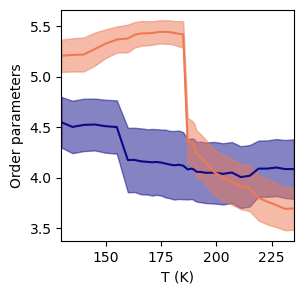

In [100]:
data={}
mean={}
error={}
fig,ax=plt.subplots(figsize=(3,3))

for idx in [0,2]:
    data[idx]=count_pts_outlier_sample_2.X_orig['mean'][count_pts_outlier_sample_2.labels_['mean']==idx]
    mean[idx]=data[idx].mean(axis=0)
    plt.plot(count_pts_outlier_sample_2.rs['T'],mean[idx],color=color_list[idx])
    error[idx]=data[idx].std(axis=0)
    plt.fill_between(count_pts_outlier_sample_2.rs['T'],mean[idx]-error[idx]/2,mean[idx]+error[idx]/2,color=color_list[idx],alpha=0.5)
ax.set_xlabel('T (K)')
ax.set_ylabel('Order parameters')
ax.margins(x=0)

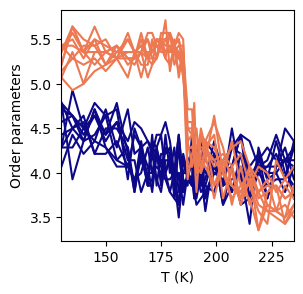

In [95]:
fig,ax=plt.subplots(figsize=(3,3))
for idx in [0,2]:
    ax.plot(count_pts_outlier_sample_2.rs['T'],data[idx][order[idx][:10]].T,color=color_list[idx])

ax.set_xlabel('T (K)')
ax.set_ylabel('Order parameters')
ax.margins(x=0)
# plt.plot(count_pts_outlier_sample_2.X_orig['mean'][count_pts_outlier_sample_2.labels_['mean']==2][:10],color=color_list[2])

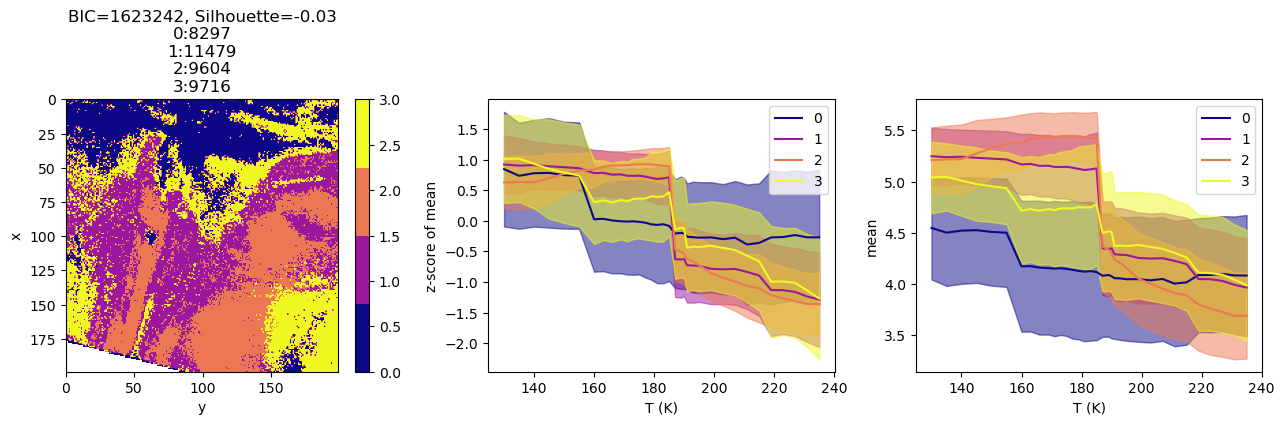

In [6]:
# fig,ax=plt.subplots(figsize=(6,3))
count_pts_outlier_sample_2.GMM_plot('mean',[0,1,2,3])

Text(0, 0.5, 'Order parameter')

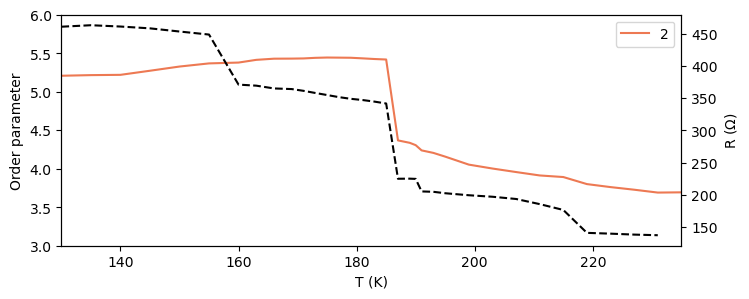

In [11]:
# fig,ax=plt.subplots(figsize=(6,3))
fig,ax=plt.subplots(figsize=(8,3))
count_pts_outlier_sample_2.GMM_plot_single('mean', [2,],errorbar=False,cond=cond_K,ax=ax,ylim=[3,6])
ax.set_xlim(T[0]+273,T[-1]+273)
ax.set_ylabel('Order parameter')
# ax.axvline(x=-88)
# ax.set_ylabel('')
# ax.set_yticks([])

In [ ]:
count_pts_outlier_sample_2.convert_real_space('mean')

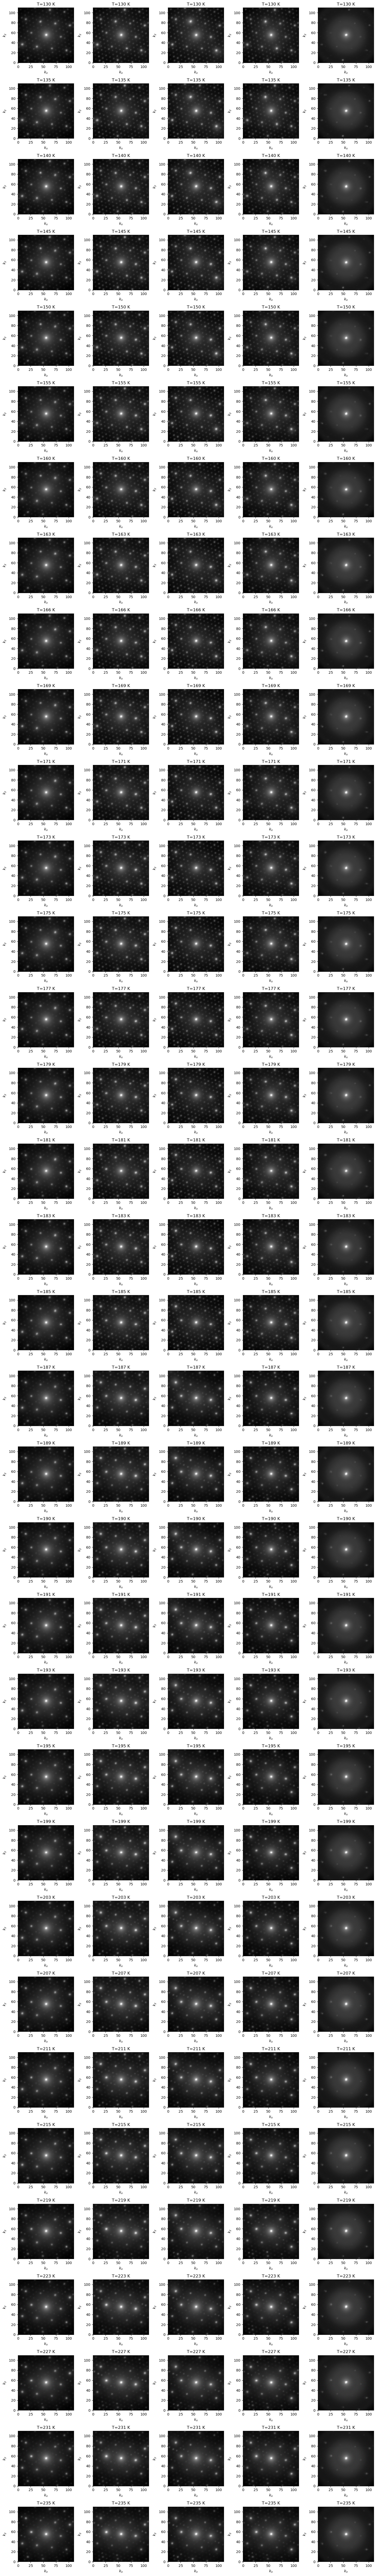

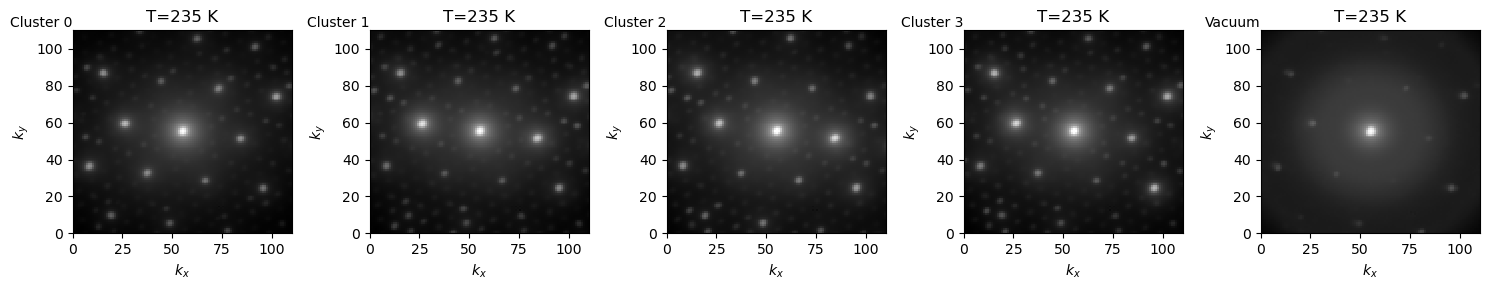

In [21]:
generate_ave_figure(I, fit_model=count_pts_outlier_sample_2,T_idx_max=None,filename='ave_cluster_real_space_outlier_no_vac',movie=True)

In [21]:
generate_ave_figure(I, fit_model=count_pts_outlier_sample_2,T_idx_max=None,filename='ave_cluster_real_space_outlier_no_vac',movie=False,figure=False,array=True)

In [41]:
with open('ave_cluster_real_space_outlier_no_vac.pickle','rb') as f:
    rs=pickle.load(f)

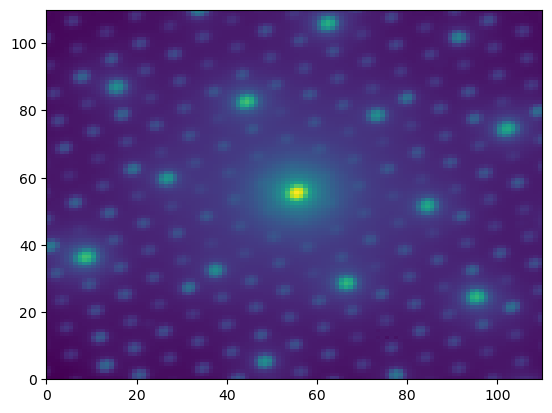

In [52]:
plt.pcolormesh(np.log10(rs[(1,130)]))

In [51]:
rs.keys()

dict_keys([(0, 130), (1, 130), (2, 130), (3, 130), (0, 135), (1, 135), (2, 135), (3, 135), (0, 140), (1, 140), (2, 140), (3, 140), (0, 145), (1, 145), (2, 145), (3, 145), (0, 150), (1, 150), (2, 150), (3, 150), (0, 155), (1, 155), (2, 155), (3, 155), (0, 160), (1, 160), (2, 160), (3, 160), (0, 163), (1, 163), (2, 163), (3, 163), (0, 166), (1, 166), (2, 166), (3, 166), (0, 169), (1, 169), (2, 169), (3, 169), (0, 171), (1, 171), (2, 171), (3, 171), (0, 173), (1, 173), (2, 173), (3, 173), (0, 175), (1, 175), (2, 175), (3, 175), (0, 177), (1, 177), (2, 177), (3, 177), (0, 179), (1, 179), (2, 179), (3, 179), (0, 181), (1, 181), (2, 181), (3, 181), (0, 183), (1, 183), (2, 183), (3, 183), (0, 185), (1, 185), (2, 185), (3, 185), (0, 187), (1, 187), (2, 187), (3, 187), (0, 189), (1, 189), (2, 189), (3, 189), (0, 190), (1, 190), (2, 190), (3, 190), (0, 191), (1, 191), (2, 191), (3, 191), (0, 193), (1, 193), (2, 193), (3, 193), (0, 195), (1, 195), (2, 195), (3, 195), (0, 199), (1, 199), (2, 199),

## Automatic bragg peaks

In [8]:
count_pts_outlier_auto=GMM_model('q_Txy_count_pts_outlier_sample_2_auto_bragg.pickle',mask=mask)

In [ ]:
count_pts_outlier_auto.GMM_hypertuning_GridSearchCV('mean')

Text(0, 0.5, 'Silhouette Score')

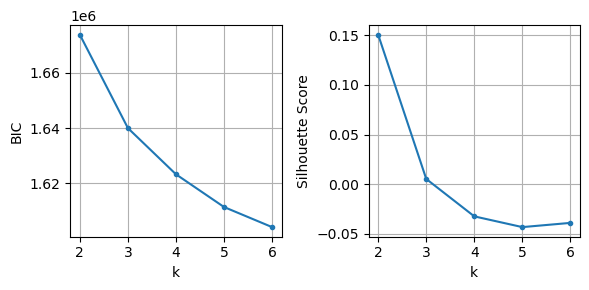

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)

axs[0].plot(count_pts_outlier_auto.k_range,count_pts_outlier_auto.search['mean'].cv_results_['mean_test_bic'],'.-')
axs[1].plot(count_pts_outlier_auto.k_range,count_pts_outlier_auto.search['mean'].cv_results_['mean_test_silhouette'],'.-')

[ax.grid('on') for ax in axs]
[ax.set_xticks(count_pts_outlier_auto.k_range) for ax in axs]
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [10]:
def test():
    print(f"{count_pts_outlier_auto.labels_grid['mean'][0,0]:.0f} {count_pts_outlier_auto.labels_grid['mean'][60,-1]:.0f} {count_pts_outlier_auto.labels_grid['mean'][-1,100]:.0f} {count_pts_outlier_auto.labels_grid['mean'][-1,-1]:.0f}")
    return (count_pts_outlier_auto.labels_grid['mean'][0,0] == 0 ) and (count_pts_outlier_auto.labels_grid['mean'][60,-1]==1) and (count_pts_outlier_auto.labels_grid['mean'][-1,100]==2)  and (count_pts_outlier_auto.labels_grid['mean'][-1,-1]==3)

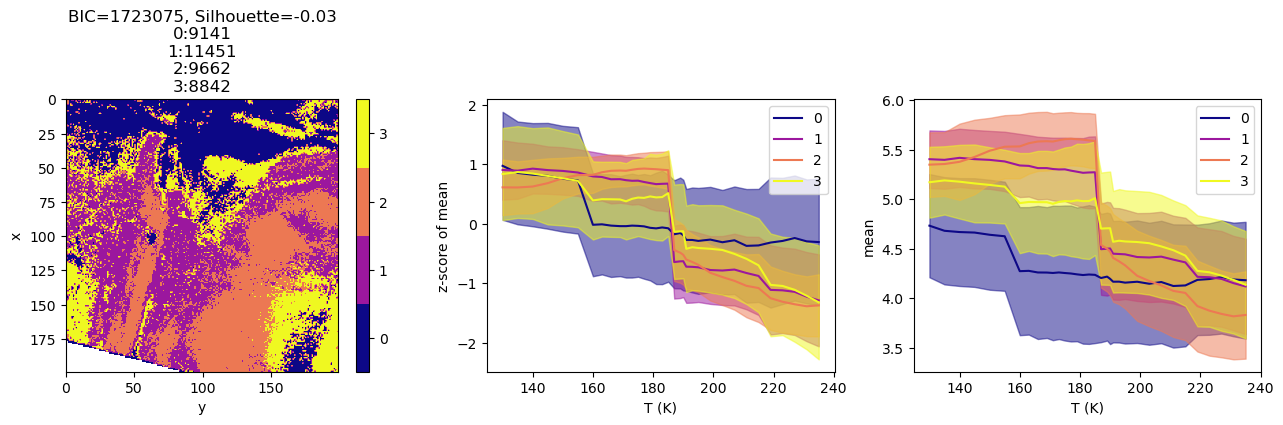

In [11]:
# while True:
    # count_pts_outlier_auto.GMM_fit('mean',k=4)
fig,ax=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts_outlier_auto.GMM_plot('mean',[0,1,2,3],ax=ax)
    # if test():
    #     break

# ax2=ax[2].twinx()
# ax2.plot(cond[:,0],cond[:,1],'k')
# ax2.set_xlim(count_pts_outlier_auto.rs['T'][0],count_pts_outlier_auto.rs['T'][-1])
# ax2.set_ylabel('R ($\Omega$)')
# ax2.tick_params(axis='y', labelcolor='c')

In [ ]:
count_pts_outlier_auto.convert_real_space('mean')

In [25]:
with open('count_pts_outlier_auto.pickle','wb') as f:
    pickle.dump(count_pts_outlier_auto,f)

In [10]:
with open('count_pts_outlier_auto.pickle','rb') as f:
    count_pts_outlier_auto=pickle.load(f)

In [ ]:
generate_ave_figure(I, fit_model=count_pts_outlier_auto,T_idx_max=None,filename='ave_cluster_real_space_auto_no_vac',array=True)

In [19]:
with open('ave_cluster_real_space_auto_no_vac.pickle','rb') as f:
    rs=pickle.load(f)

In [20]:
[k2 for k1,k2 in rs.keys() if k1 == 0]

[130,
 135,
 140,
 145,
 150,
 155,
 160,
 163,
 166,
 169,
 171,
 173,
 175,
 177,
 179,
 181,
 183,
 185,
 187,
 189,
 190,
 191,
 193,
 195,
 199,
 203,
 207,
 211,
 215,
 219,
 223,
 227,
 231,
 235]

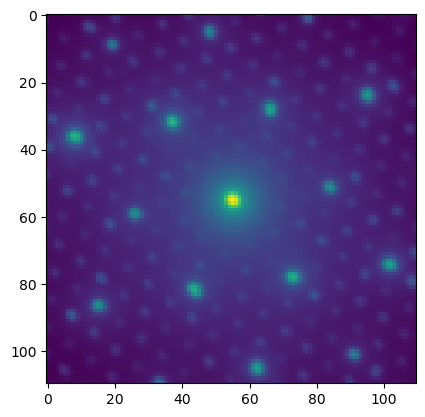

In [23]:
plt.imshow(np.log10(rs[(0, 130)]))
# plt.imshow(np.log10(rs[(0, 235)]))

# Locate Bragg peaks from intensity

In [2]:
from skimage.feature import peak_local_max

In [3]:
def generate_Bragg_peaks_vaccum(I,fit_model,T_idx=0,filename=None):
    ij=fit_model.ij
    T_list=fit_model.rs['T']
    cluster=0
    data=np.array([I[T_idx,i,j,:,:] for i,j in zip(*ij[cluster])]).mean(axis=0)
    return data

In [9]:
data=generate_Bragg_peaks_vaccum(I, fit_model=count_pts_outlier_sample_2,T_idx=33,filename=None)

NameError: name 'generate_Bragg_peaks_vaccum' is not defined

In [285]:
%matplotlib inline

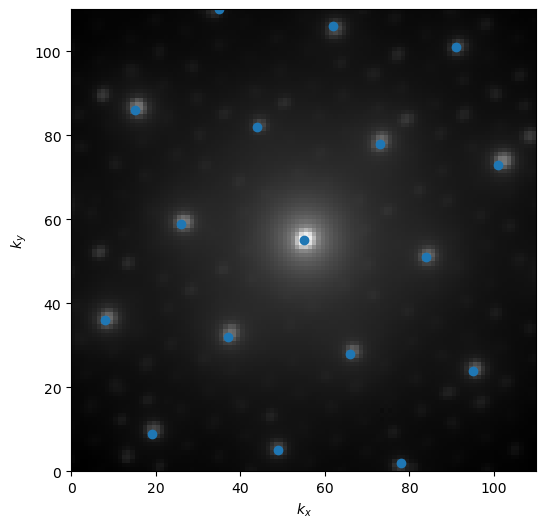

In [323]:
fig,ax=plt.subplots(figsize=(6,6))

vmin,vmax=data.min(),data.max()
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# cb=plt.colorbar(im)
# cb.ax.set_title(r'$ I(k_x,k_y) $')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')

# mask_ind=peak_local_max(np.log10(data),threshold_rel=0,min_distance=8)
# ax.scatter(mask_ind[:,1],mask_ind[:,0])
ax.scatter(brag_peaks[:,1],brag_peaks[:,0])
# ax.scatter([78],[2],c='y')

In [280]:
mask_ind

array([[ 55,  55],
       [ 59,  26],
       [ 73, 101],
       [ 86,  15],
       [ 32,  37],
       [ 36,   8],
       [ 78,  73],
       [ 51,  84],
       [ 28,  66],
       [ 24,  95],
       [ 82,  44],
       [  9,  19],
       [101,  91],
       [ 99,  77],
       [ 37, 100],
       [ 73,  10]])

In [8]:
brag_peaks=np.array([[ 55,  55],
       [ 59,  26],
       [ 73, 101],
       [ 86,  15],
       [ 32,  37],
       [ 36,   8],
       [ 78,  73],
       [ 51,  84],
       [ 28,  66],
       [ 24,  95],
       [ 82,  44],
       [  9,  19],
       [101,  91],
       [106, 62],
       [110,35],
       [5,49],
       [2,78]       ])

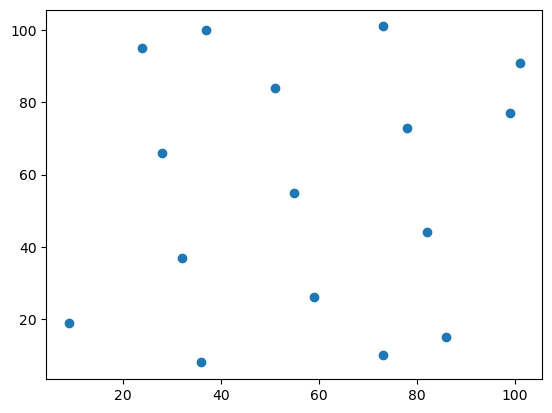

In [251]:
plt.scatter(*mask_ind.T)

In [ ]:
data=np.array([ for i,j in zip(*ij[cluster])]).mean(axis=0)

In [213]:
data=I[-1,185:,:20,:,:].mean(axis=(0,1))


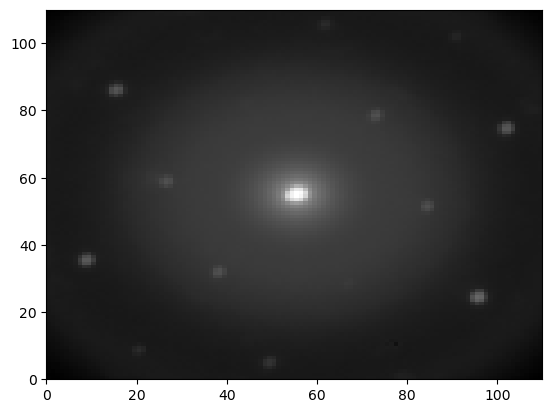

In [214]:
fig,ax=plt.subplots()
vmin,vmax=data.min(),data.max()
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))

# Create animation

In [3]:
import pickle
import h5py

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.patches import ConnectionPatch


In [5]:
workingdir='/home/shared/STEM_sample_2/'
f=h5py.File(workingdir+'data.hdf5','r')
I,T=f['I'],f['T']

In [6]:
with open('count_pts_outlier.pickle','rb') as f:
    count_pts_outlier_sample_2=pickle.load(f)

In [8]:
datamin=[]
datamax=[]
for i in range(I.shape[0]):
    data=I[i,:,:,:,:].mean(axis=(-2,-1))
    datamin.append(data.min())
    datamax.append(data.max())

In [9]:
min(datamin),max(datamax)

(59676.742, 471224.38)

In [10]:
cmap=plt.get_cmap('plasma', 4)
color_list=[cmap(idx) for idx in range(4)]

In [17]:
T[20]+273

190

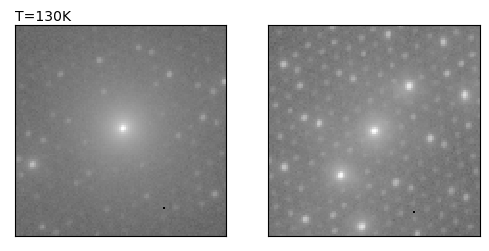

In [24]:


# create the figure and GridSpec object
# fig = plt.figure(figsize=(4,6))
# gs = GridSpec(2, 2, figure=fig, height_ratios=[2, 1],width_ratios=[1,1])

fig,axs=plt.subplots(1,2,figsize=(6,3))

# create the top panel
# ax1 = fig.add_subplot(gs[0, :])
# ax1.plot([1, 2, 3], [4, 5, 6])
T_idx=0
data=I[T_idx,:,:,:,:]
# I_r=data.mean(axis=(2,3))
# im_r=ax1.imshow(I_r,cmap='gray',norm=colors.LogNorm(vmin=min(datamin), vmax=max(datamax)))
# ax1.set_title('Real space')
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.set_aspect(1)

x1,y1=25,25
I_k1=data[x1,y1]
# create the first bottom panel
# ax2 = fig.add_subplot(gs[1, 0])
ax2=axs[0]
temp=ax2.text(0,1.02,f'T={T[T_idx]+273}K',transform=ax2.transAxes)

# ax2.plot([1, 2, 3], [4, 5, 6])
# ax2.set_title('k-space')
im_k1=ax2.pcolormesh(I_k1,cmap='gray',norm=colors.LogNorm(vmin=I_k1.min(),vmax=I_k1.max()))
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect(1)

x2,y2=75,75
I_k2=data[x2,y2]
# create the second bottom panel
# ax3 = fig.add_subplot(gs[1, 1])
ax3=axs[1]
im_k2=ax3.pcolormesh(I_k2,cmap='gray',norm=colors.LogNorm(vmin=I_k2.min(),vmax=I_k2.max()))

# ax3.plot([1, 2, 3], [4, 5, 6])
# ax3.set_title('k-space')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_aspect(1)

ax1.scatter(y1,x1,color=color_list[0],marker='o',facecolors='none')
ax1.scatter(y2,x2,color=color_list[2],marker='o',facecolors='none')


# con1_0 = ConnectionPatch(xyA=(y1-2.5,x1), xyB=(0,110), coordsA="data", coordsB="data",axesA=ax1, axesB=ax2, color=color_list[0])
# con1_1 = ConnectionPatch(xyA=(y1+2.5,x1), xyB=(110,110), coordsA="data", coordsB="data",axesA=ax1, axesB=ax2, color=color_list[0])
# con2_0 = ConnectionPatch(xyA=(y2-2.5,x2), xyB=(0,110), coordsA="data", coordsB="data",axesA=ax1, axesB=ax3, color=color_list[2])
# con2_1 = ConnectionPatch(xyA=(y2+2.5,x2), xyB=(110,110), coordsA="data", coordsB="data",axesA=ax1, axesB=ax3, color=color_list[2])
# ax2.add_artist(con1_0)
# ax2.add_artist(con1_1)
# ax2.add_artist(con2_0)
# ax2.add_artist(con2_1)

# for pos in ['top', 'bottom', 'right', 'left']:
#     ax2.spines[pos].set_edgecolor(color_list[0])
#     ax3.spines[pos].set_edgecolor(color_list[2])
#     ax2.spines[pos].set_linewidth(3)
#     ax3.spines[pos].set_linewidth(3)

# plt.tight_layout()

In [25]:
def animate(i):
    data=I[i,:,:,:,:]
    # I_r=data.mean(axis=(2,3))
    # im_r.set_array(I_r)
    temp.set_text(f'T={T[i]+273}K')
    I_k1=data[x1,y1]
    I_k2=data[x2,y2]
    im_k1.set_array(I_k1)
    im_k2.set_array(I_k2)
    return [temp,im_k1,im_k2]

In [28]:
anim = FuncAnimation(fig, animate, interval=200, frames=T.shape[0],blit=True,repeat=True)

In [ ]:
anim.save(f'movie_T.mp4',dpi=300)

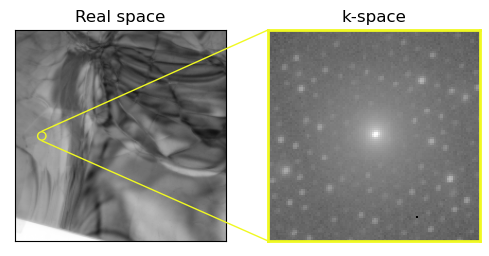

In [154]:


# create the figure and GridSpec object
fig,axs = plt.subplots(1,2,figsize=(6,3),gridspec_kw=dict(width_ratios=[1,1]))
# gs = GridSpec(2, 2, figure=fig, height_ratios=[2, 1],width_ratios=[1,1])

# create the top panel
ax1=axs[0]
T_idx=0
data=I[T_idx,:,:,:,:]
I_r=data.mean(axis=(2,3))
im_r=ax1.imshow(I_r,cmap='gray',norm=colors.LogNorm(vmin=min(datamin), vmax=max(datamax)))
ax1.set_title('Real space')
# temp=ax1.text(0,1.02,f'T={T[T_idx]+273}K',transform=ax1.transAxes)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_aspect(1)

x1,y1=100,25
I_k1=data[x1,y1]
# create the first bottom panel
ax2=axs[1]
ax2.set_title('k-space')
im_k1=ax2.pcolormesh(I_k1,cmap='gray',norm=colors.LogNorm(vmin=I_k1.min(),vmax=I_k1.max()))
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect(1)


point=ax1.scatter(y1,x1,color=color_list[3],marker='o',facecolors='none')


con1_0 = ConnectionPatch(xyA=(y1,x1-4.5), xyB=(0,110), coordsA="data", coordsB="data",axesA=ax1, axesB=ax2, color=color_list[3])
con1_1 = ConnectionPatch(xyA=(y1,x1+4.5), xyB=(0,0), coordsA="data", coordsB="data",axesA=ax1, axesB=ax2, color=color_list[3])
ax2.add_artist(con1_0)
ax2.add_artist(con1_1)

for pos in ['top', 'bottom', 'right', 'left']:
    ax2.spines[pos].set_edgecolor(color_list[3])
    ax2.spines[pos].set_linewidth(2)


In [155]:
def animate2(i):
    global con1_0, con1_1
    x1,y1=100,25+i
    data=I[T_idx,:,:,:,:]
    I_k1=data[x1,y1]
    im_k1.set_array(I_k1)
    point.set_offsets(np.array([y1,x1]))
    con1_0.remove()
    con1_1.remove()
    con1_0 = ConnectionPatch(xyA=(y1,x1-4.5), xyB=(0,110), coordsA="data", coordsB="data",axesA=ax1, axesB=ax2, color=color_list[3])
    con1_1 = ConnectionPatch(xyA=(y1,x1+4.5), xyB=(0,0), coordsA="data", coordsB="data",axesA=ax1, axesB=ax2, color=color_list[3])
    ax2.add_artist(con1_0)
    ax2.add_artist(con1_1)
    return [im_k1,point,con1_0,con1_1]

In [158]:
anim2 = FuncAnimation(fig, animate2, interval=100, frames=50,blit=True,repeat=True)

In [159]:
anim2.save(f'movie_r.mp4',dpi=300)

In [148]:
from IPython import display

In [ ]:
video = anim2.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()    